In [1]:
import wave
import json
import librosa
import csv
import numpy as np
from pywt import wavedec
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2024-01-15 22:59:03.402453: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 22:59:03.439192: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 22:59:03.439225: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 22:59:03.439249: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 22:59:03.445835: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 22:59:03.446267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import wave
import json

def reset_csv():
  header = 'filename'
  for i in range(1, 41):
      header += f' mfcc{i}'
  for i in range(1, 13):
    header += f' chroma{i}'
  for i in range(1, 61):
    header += f' cqt{i}'
  header += ' label'
  header = header.split()
  file = open('testing.csv', 'w', newline='')
  with file:
      writer = csv.writer(file)
      writer.writerow(header)

In [4]:
def getModelArray(model_name):
  model_path = '../modelh5/'+model_name+'/best_model/'
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(model_path)):
    filenames.sort()
    filenames = filenames[10:] + filenames[:10]
    # cut each 10 array
    filenames = [filenames[i:i + 10] for i in range(0, len(filenames), 10)]
    return filenames[0], filenames[1], filenames[2], filenames[3], filenames[4], filenames[5], filenames[6], filenames[7], filenames[8], filenames[9]

def getPathModel(model_name):
  a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = getModelArray(model_name)
  # switch index 2 to 10
  hasil = []
  for i in [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10]:
    a = i[1]
    i.pop(1)
    i.append(a)
    for j in range(len(i)):
      i[j] = '../modelh5/'+model_name + '/best_model/' + i[j]
  return a1, a2, a3, a4, a5, a6, a7, a8, a9, a10

In [5]:
def testingVHD(array, db):
    index_db = 0
    accuracy_all = []
    precision_all = []
    sensitivity_all = []
    specificity_all = []
    f1_score_all = []

    for model_path in array:
        print("=======================================================")
        print("Processing "+ model_path)
        print("=======================================================")
        dataset_path = '../../data/testing_10/'
        reset_csv()

        for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
                # ensure we're processing a genre sub-folder level
                if dirpath is not dataset_path:
                    semantic_label = dirpath.split("/")[-1]
                    for f in filenames:
                        file_path = os.path.join(dirpath, f)
                        to_append = f'{file_path}'
                        # print(file_path)
                        y, sr = librosa.load(file_path, mono=True, duration=3, sr=8000)
                        coeffs = wavedec(y, f'db{db}', level=10)
                        cA,cD10,cD9,cD8,cD7,cD6,cD5,cD4,cD3,cD2, cD1 = coeffs
                        list_cd = [cD1, cD2, cD3, cD4, cD5, cD6, cD7, cD8, cD9, cD10]
                        mfcc = librosa.feature.mfcc(y=list_cd[index_db], sr=8000, n_mfcc=40, n_fft=2048, hop_length=512, n_mels=128)
                        rms = librosa.feature.chroma_stft(y=list_cd[index_db], sr=8000)
                        cqt = np.abs(librosa.cqt(y=list_cd[index_db], sr=sr, n_bins=60))
                        combined_features = np.concatenate((mfcc, rms, cqt), axis=0)
                        to_append = f'{file_path}'
                        for e in combined_features:
                            to_append += f' {np.mean(e.T, axis=0)}'
                        to_append += f' {semantic_label}'
                        file = open('testing.csv', 'a', newline='')
                        with file:
                            writer = csv.writer(file)
                            writer.writerow(to_append.split())
        index_db += 1
        data = pd.read_csv('./testing.csv')
        
        lb = LabelEncoder()
        X = np.expand_dims(data.drop(['label', 'filename'], axis=1), axis=2)
        y = np.expand_dims(data.iloc[:, -1], axis=1)


        model = tf.keras.models.load_model(model_path)
        pred = model.predict(X)
        hasil = []
        class_labels = ['AS', 'MR', 'MS', 'MVP', 'N']
        # class_labels = ['MVP', 'MS', 'N', 'MR', 'AS']
        for predic in pred:
            cek = np.argmax(predic)
            hasil.append(class_labels[cek])
        # y_p = np.argmax(pred, axis=1)

        cm = confusion_matrix(y, hasil)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AS', 'MR', 'MS', 'MVP', 'N'])
        disp.plot()
        plt.show()

        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)

        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)

        print("Accuracy :" , ACC, 'mean: ', np.mean(ACC))
        print("Precision :" , PPV, 'mean: ', np.mean(PPV))
        print("Sensitivity :" , TPR, 'mean: ', np.mean(TPR))
        print("Specificity :" , TNR, 'mean: ', np.mean(TNR))
        print("f1_score:", 2 * (PPV * TPR) / (PPV + TPR), 'mean: ', np.mean(2 * (PPV * TPR) / (PPV + TPR)))

        accuracy_all.append(np.mean(ACC))
        precision_all.append(np.mean(PPV))
        sensitivity_all.append(np.mean(TPR))
        specificity_all.append(np.mean(TNR))
        f1_score_all.append(np.mean(2 * (PPV * TPR) / (PPV + TPR)))

        print("\n\n")

    print("=======================================================")
    print("Accuracy All :" , accuracy_all)
    print("Precision All :" , precision_all)
    print("Sensitivity All :" , sensitivity_all)
    print("Specificity All :" , specificity_all)
    print("f1_score All :", f1_score_all)
    print("=======================================================")




In [9]:
a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = getPathModel("RNN_NT")

Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb1L1.csv_2.h5
4/4 [==============================] - 0s 5ms/step


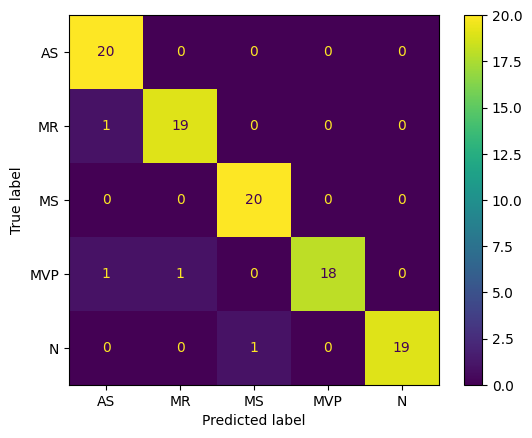

Accuracy : [0.98 0.98 0.99 0.98 0.99] mean:  0.984
Precision : [0.90909091 0.95       0.95238095 1.         1.        ] mean:  0.9622943722943722
Sensitivity : [1.   0.95 1.   0.9  0.95] mean:  0.96
Specificity : [0.975  0.9875 0.9875 1.     1.    ] mean:  0.99
f1_score: [0.95238095 0.95       0.97560976 0.94736842 0.97435897] mean:  0.9599436207780239



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb1L2.csv_2.h5
4/4 [==============================] - 0s 5ms/step


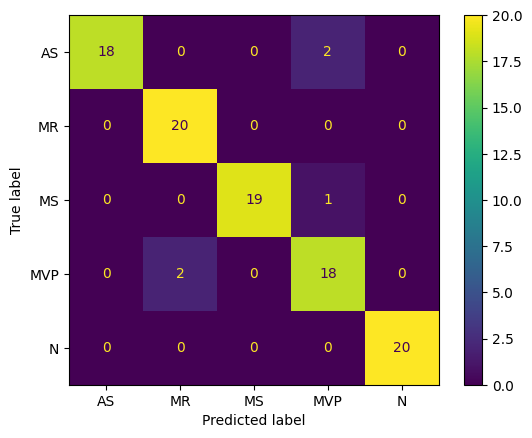

Accuracy : [0.98 0.98 0.99 0.95 1.  ] mean:  0.9800000000000001
Precision : [1.         0.90909091 1.         0.85714286 1.        ] mean:  0.9532467532467532
Sensitivity : [0.9  1.   0.95 0.9  1.  ] mean:  0.95
Specificity : [1.     0.975  1.     0.9625 1.    ] mean:  0.9875
f1_score: [0.94736842 0.95238095 0.97435897 0.87804878 1.        ] mean:  0.9504314256560725



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb1L3.csv_2.h5
4/4 [==============================] - 0s 4ms/step


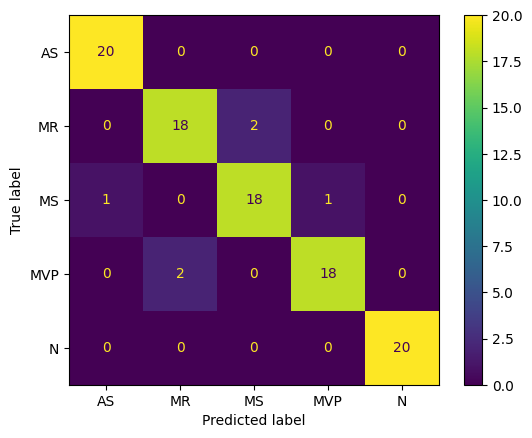

Accuracy : [0.99 0.96 0.96 0.97 1.  ] mean:  0.976
Precision : [0.95238095 0.9        0.9        0.94736842 1.        ] mean:  0.9399498746867166
Sensitivity : [1.  0.9 0.9 0.9 1. ] mean:  0.9399999999999998
Specificity : [0.9875 0.975  0.975  0.9875 1.    ] mean:  0.985
f1_score: [0.97560976 0.9        0.9        0.92307692 1.        ] mean:  0.9397373358348968



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb1L4.csv_2.h5
4/4 [==============================] - 0s 5ms/step


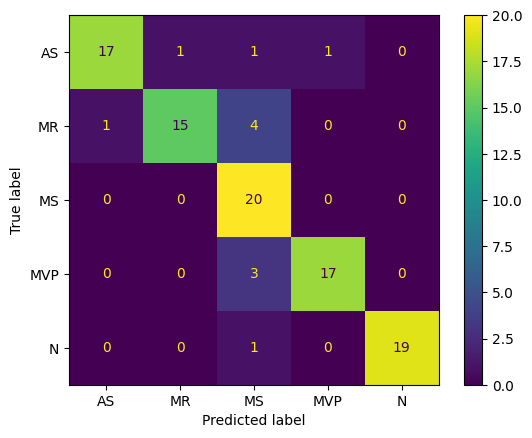

Accuracy : [0.96 0.94 0.91 0.96 0.99] mean:  0.952
Precision : [0.94444444 0.9375     0.68965517 0.94444444 1.        ] mean:  0.9032088122605364
Sensitivity : [0.85 0.75 1.   0.85 0.95] mean:  0.8800000000000001
Specificity : [0.9875 0.9875 0.8875 0.9875 1.    ] mean:  0.97
f1_score: [0.89473684 0.83333333 0.81632653 0.89473684 0.97435897] mean:  0.8826985045030158



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb1L5.csv_5.h5
4/4 [==============================] - 0s 5ms/step


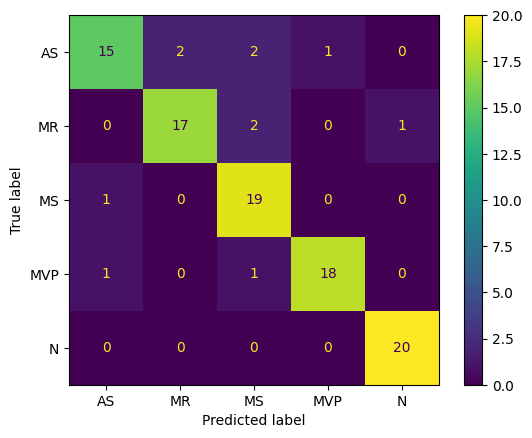

Accuracy : [0.93 0.95 0.94 0.97 0.99] mean:  0.9560000000000001
Precision : [0.88235294 0.89473684 0.79166667 0.94736842 0.95238095] mean:  0.8937011646763968
Sensitivity : [0.75 0.85 0.95 0.9  1.  ] mean:  0.8899999999999999
Specificity : [0.975  0.975  0.9375 0.9875 0.9875] mean:  0.9724999999999999
f1_score: [0.81081081 0.87179487 0.86363636 0.92307692 0.97560976] mean:  0.8889857450833061



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb1L6.csv_2.h5
4/4 [==============================] - 0s 5ms/step


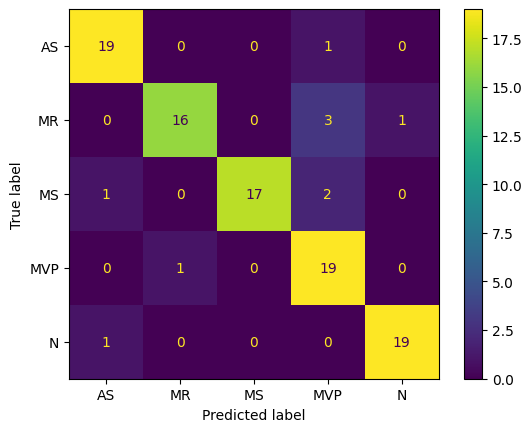

Accuracy : [0.97 0.95 0.97 0.93 0.98] mean:  0.96
Precision : [0.9047619  0.94117647 1.         0.76       0.95      ] mean:  0.9111876750700281
Sensitivity : [0.95 0.8  0.85 0.95 0.95] mean:  0.9
Specificity : [0.975  0.9875 1.     0.925  0.9875] mean:  0.975
f1_score: [0.92682927 0.86486486 0.91891892 0.84444444 0.95      ] mean:  0.9010114993041822



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb1L7.csv_5.h5
4/4 [==============================] - 0s 5ms/step


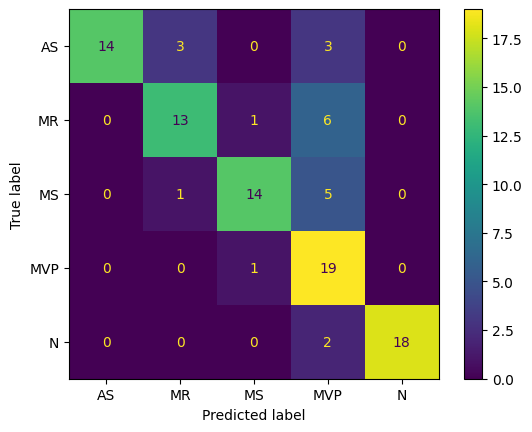

Accuracy : [0.94 0.89 0.92 0.83 0.98] mean:  0.9120000000000001
Precision : [1.         0.76470588 0.875      0.54285714 1.        ] mean:  0.8365126050420167
Sensitivity : [0.7  0.65 0.7  0.95 0.9 ] mean:  0.78
Specificity : [1.    0.95  0.975 0.8   1.   ] mean:  0.945
f1_score: [0.82352941 0.7027027  0.77777778 0.69090909 0.94736842] mean:  0.7884574808413818



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb1L8.csv_4.h5
4/4 [==============================] - 0s 4ms/step


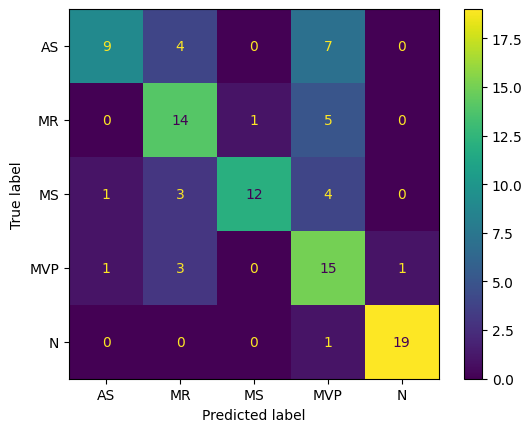

Accuracy : [0.87 0.84 0.91 0.78 0.98] mean:  0.8760000000000001
Precision : [0.81818182 0.58333333 0.92307692 0.46875    0.95      ] mean:  0.748668414918415
Sensitivity : [0.45 0.7  0.6  0.75 0.95] mean:  0.6900000000000001
Specificity : [0.975  0.875  0.9875 0.7875 0.9875] mean:  0.9225000000000001
f1_score: [0.58064516 0.63636364 0.72727273 0.57692308 0.95      ] mean:  0.6942409203699528



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb1L9.csv_2.h5
4/4 [==============================] - 0s 5ms/step


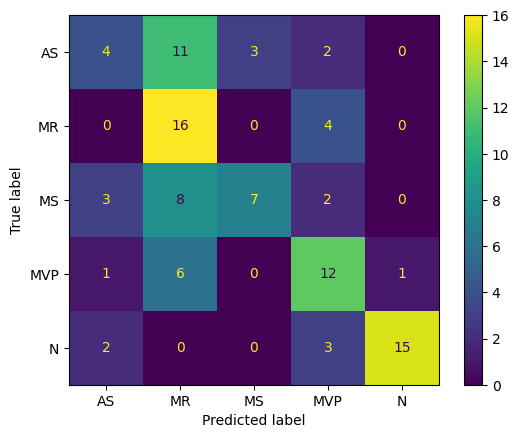

Accuracy : [0.78 0.71 0.84 0.81 0.94] mean:  0.8160000000000001
Precision : [0.4        0.3902439  0.7        0.52173913 0.9375    ] mean:  0.5898966065747614
Sensitivity : [0.2  0.8  0.35 0.6  0.75] mean:  0.54
Specificity : [0.925  0.6875 0.9625 0.8625 0.9875] mean:  0.885
f1_score: [0.26666667 0.52459016 0.46666667 0.55813953 0.83333333] mean:  0.5298792730969628



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb1L10.csv_5.h5
4/4 [==============================] - 0s 5ms/step


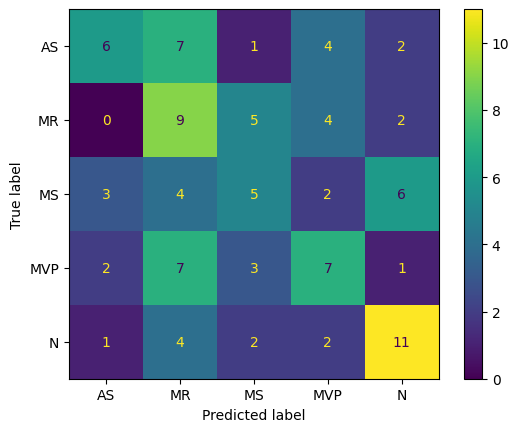

Accuracy : [0.8  0.67 0.74 0.75 0.8 ] mean:  0.752
Precision : [0.5        0.29032258 0.3125     0.36842105 0.5       ] mean:  0.39424872665534805
Sensitivity : [0.3  0.45 0.25 0.35 0.55] mean:  0.38
Specificity : [0.925  0.725  0.8625 0.85   0.8625] mean:  0.8450000000000001
f1_score: [0.375      0.35294118 0.27777778 0.35897436 0.52380952] mean:  0.37770056740644975



Accuracy All : [0.984, 0.9800000000000001, 0.976, 0.952, 0.9560000000000001, 0.96, 0.9120000000000001, 0.8760000000000001, 0.8160000000000001, 0.752]
Precision All : [0.9622943722943722, 0.9532467532467532, 0.9399498746867166, 0.9032088122605364, 0.8937011646763968, 0.9111876750700281, 0.8365126050420167, 0.748668414918415, 0.5898966065747614, 0.39424872665534805]
Sensitivity All : [0.96, 0.95, 0.9399999999999998, 0.8800000000000001, 0.8899999999999999, 0.9, 0.78, 0.6900000000000001, 0.54, 0.38]
Specificity All : [0.99, 0.9875, 0.985, 0.97, 0.9724999999999999, 0.975, 0.945, 0.9225000000000001, 0.885, 0.8450000000000001

In [10]:
testingVHD(a1, 1)

Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb2L1.csv_2.h5


4/4 [==============================] - 0s 5ms/step


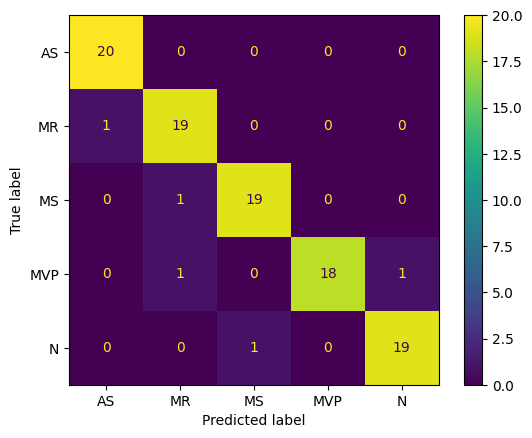

Accuracy : [0.99 0.97 0.98 0.98 0.98] mean:  0.9800000000000001
Precision : [0.95238095 0.9047619  0.95       1.         0.95      ] mean:  0.9514285714285714
Sensitivity : [1.   0.95 0.95 0.9  0.95] mean:  0.95
Specificity : [0.9875 0.975  0.9875 1.     0.9875] mean:  0.9875
f1_score: [0.97560976 0.92682927 0.95       0.94736842 0.95      ] mean:  0.9499614890885753



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb2L2.csv_2.h5
4/4 [==============================] - 0s 5ms/step


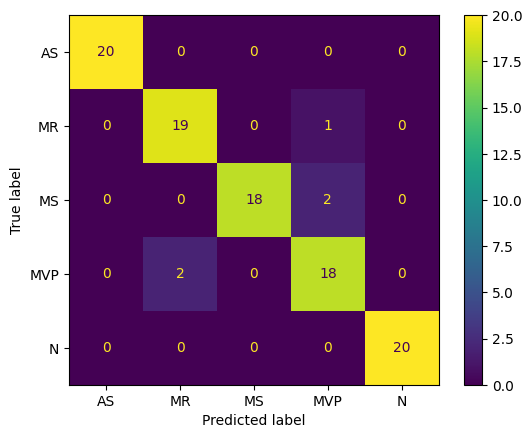

Accuracy : [1.   0.97 0.98 0.95 1.  ] mean:  0.9800000000000001
Precision : [1.         0.9047619  1.         0.85714286 1.        ] mean:  0.9523809523809523
Sensitivity : [1.   0.95 0.9  0.9  1.  ] mean:  0.95
Specificity : [1.     0.975  1.     0.9625 1.    ] mean:  0.9875
f1_score: [1.         0.92682927 0.94736842 0.87804878 1.        ] mean:  0.9504492939666239



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb2L3.csv_2.h5
4/4 [==============================] - 0s 4ms/step


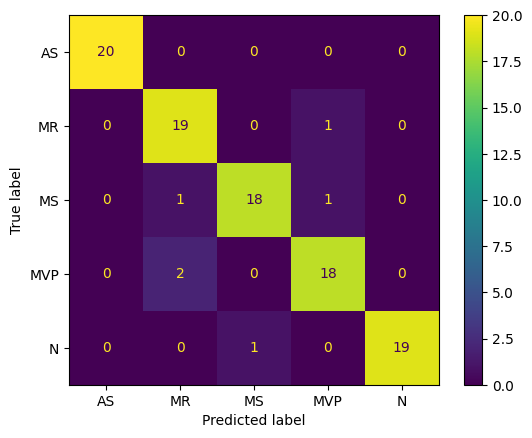

Accuracy : [1.   0.96 0.97 0.96 0.99] mean:  0.976
Precision : [1.         0.86363636 0.94736842 0.9        1.        ] mean:  0.9422009569377992
Sensitivity : [1.   0.95 0.9  0.9  0.95] mean:  0.9400000000000001
Specificity : [1.     0.9625 0.9875 0.975  1.    ] mean:  0.9850000000000001
f1_score: [1.         0.9047619  0.92307692 0.9        0.97435897] mean:  0.9404395604395603



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb2L4.csv_2.h5
4/4 [==============================] - 0s 5ms/step


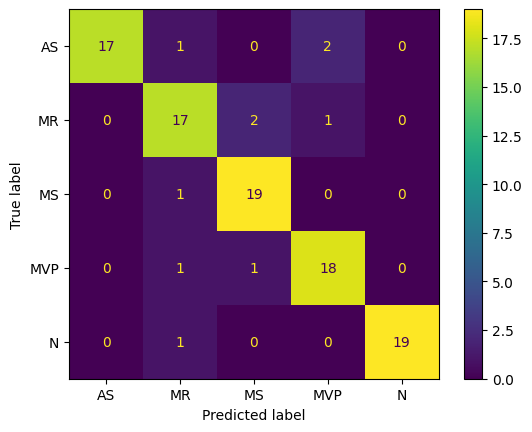

Accuracy : [0.97 0.93 0.96 0.95 0.99] mean:  0.96
Precision : [1.         0.80952381 0.86363636 0.85714286 1.        ] mean:  0.906060606060606
Sensitivity : [0.85 0.85 0.95 0.9  0.95] mean:  0.9
Specificity : [1.     0.95   0.9625 0.9625 1.    ] mean:  0.975
f1_score: [0.91891892 0.82926829 0.9047619  0.87804878 0.97435897] mean:  0.9010713742421059



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb2L5.csv_5.h5
4/4 [==============================] - 0s 4ms/step


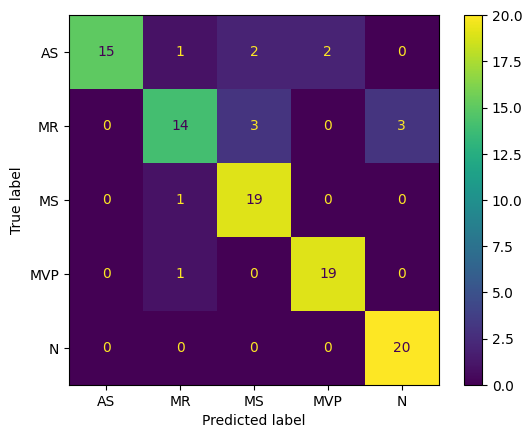

Accuracy : [0.95 0.91 0.94 0.97 0.97] mean:  0.9479999999999998
Precision : [1.         0.82352941 0.79166667 0.9047619  0.86956522] mean:  0.8779046401169163
Sensitivity : [0.75 0.7  0.95 0.95 1.  ] mean:  0.8699999999999999
Specificity : [1.     0.9625 0.9375 0.975  0.9625] mean:  0.9675
f1_score: [0.85714286 0.75675676 0.86363636 0.92682927 0.93023256] mean:  0.866919560793639



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb2L6.csv_2.h5
4/4 [==============================] - 0s 4ms/step


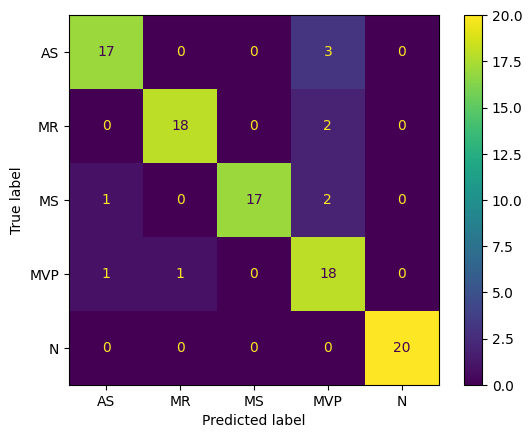

Accuracy : [0.95 0.97 0.97 0.91 1.  ] mean:  0.96
Precision : [0.89473684 0.94736842 1.         0.72       1.        ] mean:  0.9124210526315789
Sensitivity : [0.85 0.9  0.85 0.9  1.  ] mean:  0.9
Specificity : [0.975  0.9875 1.     0.9125 1.    ] mean:  0.975
f1_score: [0.87179487 0.92307692 0.91891892 0.8        1.        ] mean:  0.9027581427581428



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb2L7.csv_2.h5
4/4 [==============================] - 0s 4ms/step


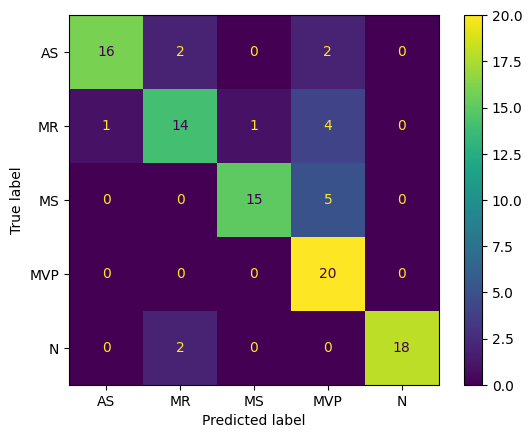

Accuracy : [0.95 0.9  0.94 0.89 0.98] mean:  0.932
Precision : [0.94117647 0.77777778 0.9375     0.64516129 1.        ] mean:  0.8603231077377188
Sensitivity : [0.8  0.7  0.75 1.   0.9 ] mean:  0.8300000000000001
Specificity : [0.9875 0.95   0.9875 0.8625 1.    ] mean:  0.9574999999999999
f1_score: [0.86486486 0.73684211 0.83333333 0.78431373 0.94736842] mean:  0.8333444900008367



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb2L8.csv_5.h5
4/4 [==============================] - 0s 5ms/step


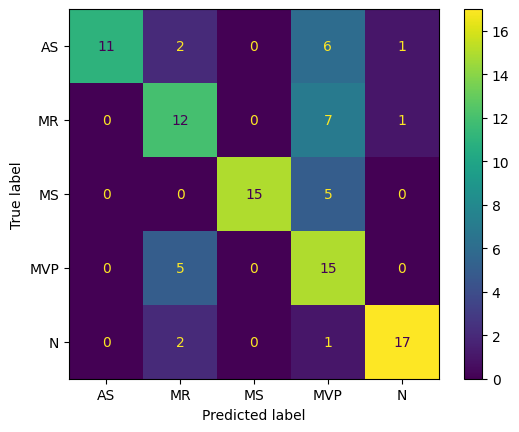

Accuracy : [0.91 0.83 0.95 0.76 0.95] mean:  0.8800000000000001
Precision : [1.         0.57142857 1.         0.44117647 0.89473684] mean:  0.781468376824414
Sensitivity : [0.55 0.6  0.75 0.75 0.85] mean:  0.7
Specificity : [1.     0.8875 1.     0.7625 0.975 ] mean:  0.925
f1_score: [0.70967742 0.58536585 0.85714286 0.55555556 0.87179487] mean:  0.715907311501332



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb2L9.csv_4.h5
4/4 [==============================] - 0s 4ms/step


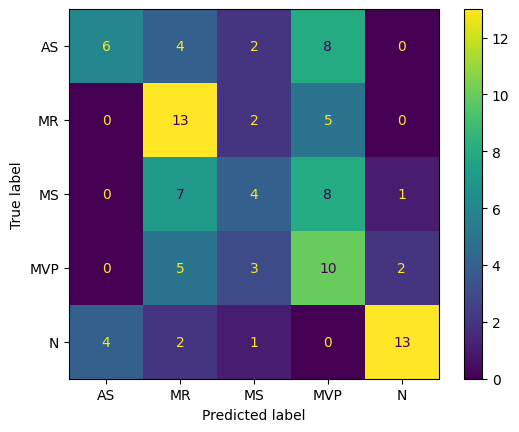

Accuracy : [0.82 0.75 0.76 0.69 0.9 ] mean:  0.784
Precision : [0.6        0.41935484 0.33333333 0.32258065 0.8125    ] mean:  0.4975537634408601
Sensitivity : [0.3  0.65 0.2  0.5  0.65] mean:  0.45999999999999996
Specificity : [0.95   0.775  0.9    0.7375 0.9625] mean:  0.865
f1_score: [0.4        0.50980392 0.25       0.39215686 0.72222222] mean:  0.4548366013071895



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb2L10.csv_1.h5
4/4 [==============================] - 0s 4ms/step


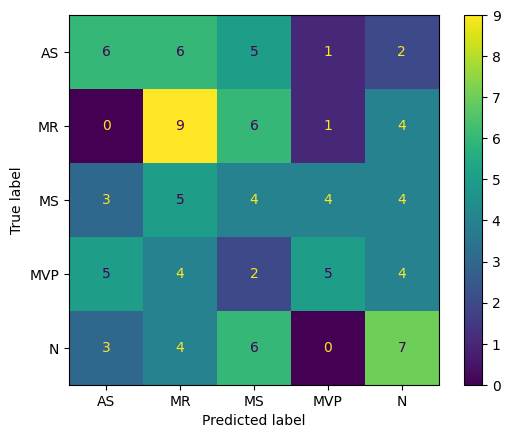

Accuracy : [0.75 0.7  0.65 0.79 0.73] mean:  0.724
Precision : [0.35294118 0.32142857 0.17391304 0.45454545 0.33333333] mean:  0.3272323158512417
Sensitivity : [0.3  0.45 0.2  0.25 0.35] mean:  0.30999999999999994
Specificity : [0.8625 0.7625 0.7625 0.925  0.825 ] mean:  0.8275
f1_score: [0.32432432 0.375      0.18604651 0.32258065 0.34146341] mean:  0.3098829791495336



Accuracy All : [0.9800000000000001, 0.9800000000000001, 0.976, 0.96, 0.9479999999999998, 0.96, 0.932, 0.8800000000000001, 0.784, 0.724]
Precision All : [0.9514285714285714, 0.9523809523809523, 0.9422009569377992, 0.906060606060606, 0.8779046401169163, 0.9124210526315789, 0.8603231077377188, 0.781468376824414, 0.4975537634408601, 0.3272323158512417]
Sensitivity All : [0.95, 0.95, 0.9400000000000001, 0.9, 0.8699999999999999, 0.9, 0.8300000000000001, 0.7, 0.45999999999999996, 0.30999999999999994]
Specificity All : [0.9875, 0.9875, 0.9850000000000001, 0.975, 0.9675, 0.975, 0.9574999999999999, 0.925, 0.865, 0.8275]
f1_scor

In [11]:
testingVHD(a2, 2)

Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb3L1.csv_3.h5


4/4 [==============================] - 0s 4ms/step


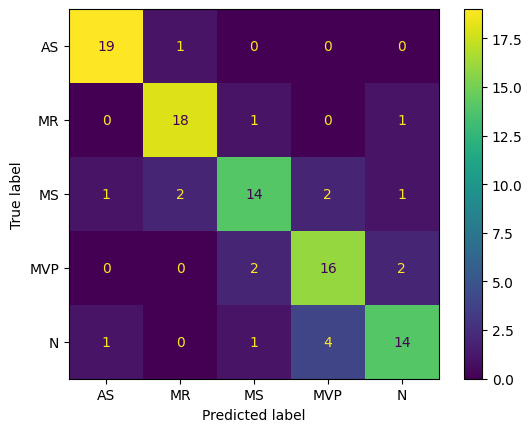

Accuracy : [0.97 0.95 0.9  0.9  0.9 ] mean:  0.924
Precision : [0.9047619  0.85714286 0.77777778 0.72727273 0.77777778] mean:  0.808946608946609
Sensitivity : [0.95 0.9  0.7  0.8  0.7 ] mean:  0.8099999999999999
Specificity : [0.975  0.9625 0.95   0.925  0.95  ] mean:  0.9525
f1_score: [0.92682927 0.87804878 0.73684211 0.76190476 0.73684211] mean:  0.8080934042423129



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb3L2.csv_2.h5
4/4 [==============================] - 0s 4ms/step


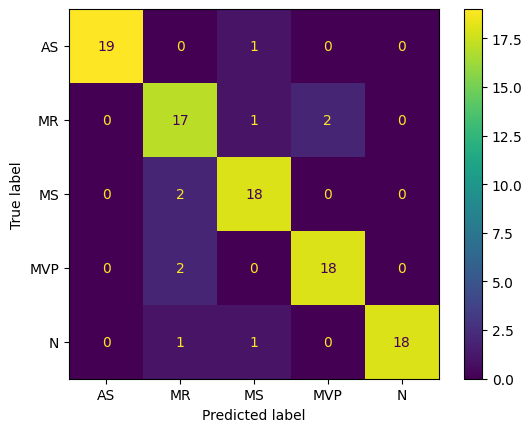

Accuracy : [0.99 0.92 0.95 0.96 0.98] mean:  0.9600000000000002
Precision : [1.         0.77272727 0.85714286 0.9        1.        ] mean:  0.9059740259740259
Sensitivity : [0.95 0.85 0.9  0.9  0.9 ] mean:  0.9
Specificity : [1.     0.9375 0.9625 0.975  1.    ] mean:  0.975
f1_score: [0.97435897 0.80952381 0.87804878 0.9        0.94736842] mean:  0.9018599970846439



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb3L3.csv_5.h5
4/4 [==============================] - 0s 5ms/step


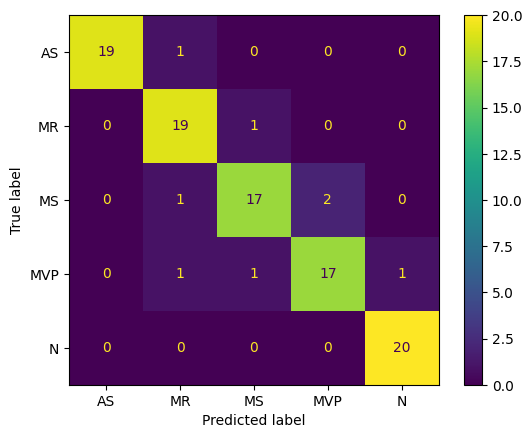

Accuracy : [0.99 0.96 0.95 0.95 0.99] mean:  0.968
Precision : [1.         0.86363636 0.89473684 0.89473684 0.95238095] mean:  0.9210982000455685
Sensitivity : [0.95 0.95 0.85 0.85 1.  ] mean:  0.9199999999999999
Specificity : [1.     0.9625 0.975  0.975  0.9875] mean:  0.9800000000000001
f1_score: [0.97435897 0.9047619  0.87179487 0.87179487 0.97560976] mean:  0.9196640757616368



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb3L4.csv_2.h5
4/4 [==============================] - 0s 5ms/step


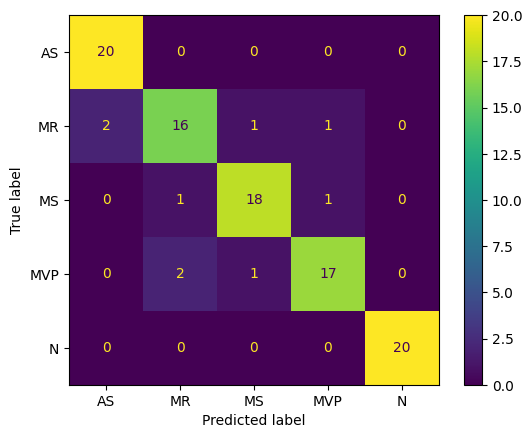

Accuracy : [0.98 0.93 0.96 0.95 1.  ] mean:  0.9640000000000001
Precision : [0.90909091 0.84210526 0.9        0.89473684 1.        ] mean:  0.9091866028708134
Sensitivity : [1.   0.8  0.9  0.85 1.  ] mean:  0.9100000000000001
Specificity : [0.975  0.9625 0.975  0.975  1.    ] mean:  0.9775
f1_score: [0.95238095 0.82051282 0.9        0.87179487 1.        ] mean:  0.908937728937729



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb3L5.csv_2.h5
4/4 [==============================] - 0s 4ms/step


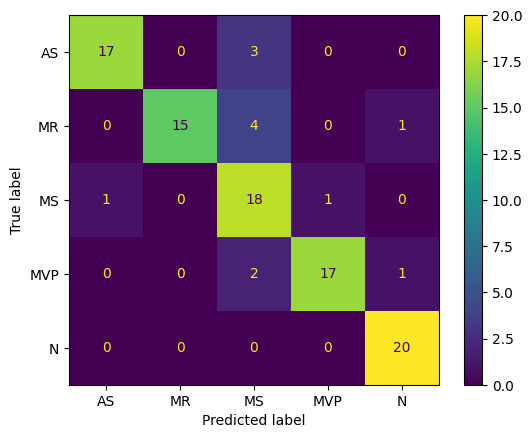

Accuracy : [0.96 0.95 0.89 0.96 0.98] mean:  0.9480000000000001
Precision : [0.94444444 1.         0.66666667 0.94444444 0.90909091] mean:  0.8929292929292929
Sensitivity : [0.85 0.75 0.9  0.85 1.  ] mean:  0.8699999999999999
Specificity : [0.9875 1.     0.8875 0.9875 0.975 ] mean:  0.9674999999999999
f1_score: [0.89473684 0.85714286 0.76595745 0.89473684 0.95238095] mean:  0.8729909881085692



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb3L6.csv_2.h5
4/4 [==============================] - 0s 4ms/step


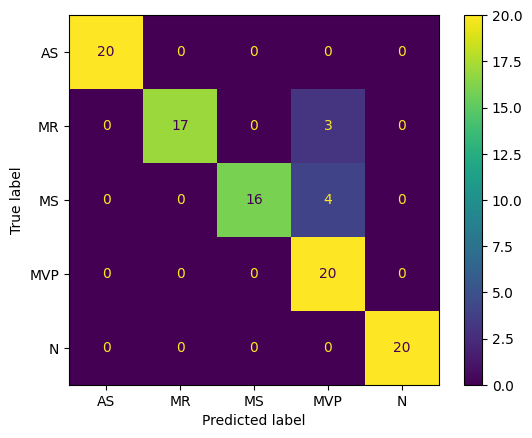

Accuracy : [1.   0.97 0.96 0.93 1.  ] mean:  0.9719999999999999
Precision : [1.         1.         1.         0.74074074 1.        ] mean:  0.9481481481481481
Sensitivity : [1.   0.85 0.8  1.   1.  ] mean:  0.93
Specificity : [1.     1.     1.     0.9125 1.    ] mean:  0.9824999999999999
f1_score: [1.         0.91891892 0.88888889 0.85106383 1.        ] mean:  0.9317743275190082



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb3L7.csv_5.h5
4/4 [==============================] - 0s 4ms/step


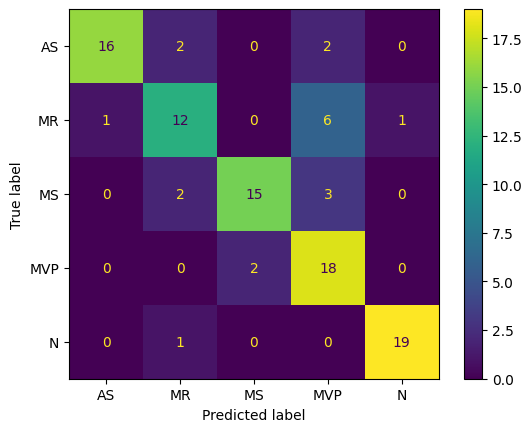

Accuracy : [0.95 0.87 0.93 0.87 0.98] mean:  0.9199999999999999
Precision : [0.94117647 0.70588235 0.88235294 0.62068966 0.95      ] mean:  0.8200202839756592
Sensitivity : [0.8  0.6  0.75 0.9  0.95] mean:  0.8
Specificity : [0.9875 0.9375 0.975  0.8625 0.9875] mean:  0.95
f1_score: [0.86486486 0.64864865 0.81081081 0.73469388 0.95      ] mean:  0.8018036403750688



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb3L8.csv_5.h5
4/4 [==============================] - 0s 6ms/step


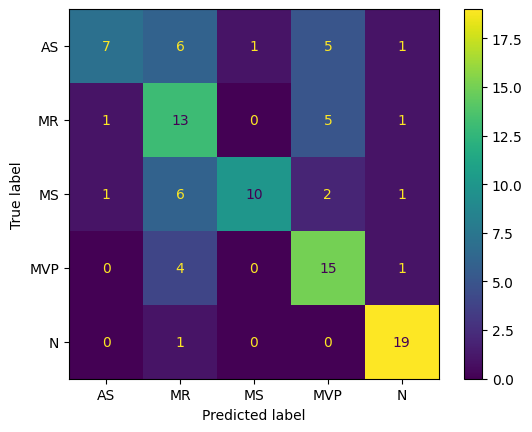

Accuracy : [0.85 0.76 0.89 0.83 0.95] mean:  0.8560000000000001
Precision : [0.77777778 0.43333333 0.90909091 0.55555556 0.82608696] mean:  0.700368906455863
Sensitivity : [0.35 0.65 0.5  0.75 0.95] mean:  0.64
Specificity : [0.975  0.7875 0.9875 0.85   0.95  ] mean:  0.9099999999999999
f1_score: [0.48275862 0.52       0.64516129 0.63829787 0.88372093] mean:  0.633987742717044



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb3L9.csv_3.h5
4/4 [==============================] - 0s 4ms/step


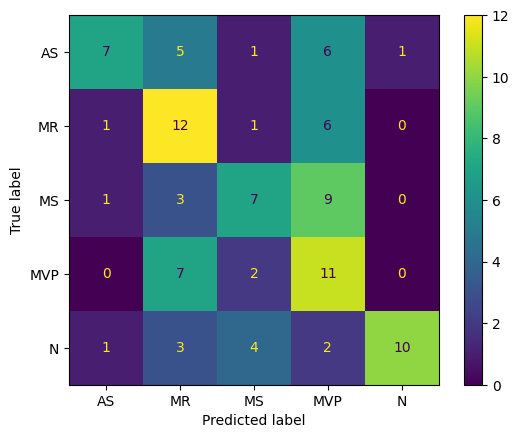

Accuracy : [0.84 0.74 0.79 0.68 0.89] mean:  0.788
Precision : [0.7        0.4        0.46666667 0.32352941 0.90909091] mean:  0.5598573975044563
Sensitivity : [0.35 0.6  0.35 0.55 0.5 ] mean:  0.4699999999999999
Specificity : [0.9625 0.775  0.9    0.7125 0.9875] mean:  0.8675
f1_score: [0.46666667 0.48       0.4        0.40740741 0.64516129] mean:  0.4798470728793309



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb3L10.csv_2.h5
4/4 [==============================] - 0s 5ms/step


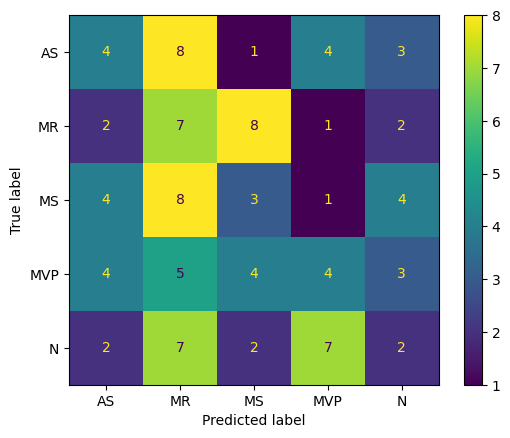

Accuracy : [0.72 0.59 0.68 0.71 0.7 ] mean:  0.68
Precision : [0.25       0.2        0.16666667 0.23529412 0.14285714] mean:  0.19896358543417367
Sensitivity : [0.2  0.35 0.15 0.2  0.1 ] mean:  0.20000000000000004
Specificity : [0.85   0.65   0.8125 0.8375 0.85  ] mean:  0.8
f1_score: [0.22222222 0.25454545 0.15789474 0.21621622 0.11764706] mean:  0.19370513772990555



Accuracy All : [0.924, 0.9600000000000002, 0.968, 0.9640000000000001, 0.9480000000000001, 0.9719999999999999, 0.9199999999999999, 0.8560000000000001, 0.788, 0.68]
Precision All : [0.808946608946609, 0.9059740259740259, 0.9210982000455685, 0.9091866028708134, 0.8929292929292929, 0.9481481481481481, 0.8200202839756592, 0.700368906455863, 0.5598573975044563, 0.19896358543417367]
Sensitivity All : [0.8099999999999999, 0.9, 0.9199999999999999, 0.9100000000000001, 0.8699999999999999, 0.93, 0.8, 0.64, 0.4699999999999999, 0.20000000000000004]
Specificity All : [0.9525, 0.975, 0.9800000000000001, 0.9775, 0.9674999999999999, 0.98

In [12]:
testingVHD(a3, 3)

Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb4L1.csv_2.h5


4/4 [==============================] - 0s 5ms/step


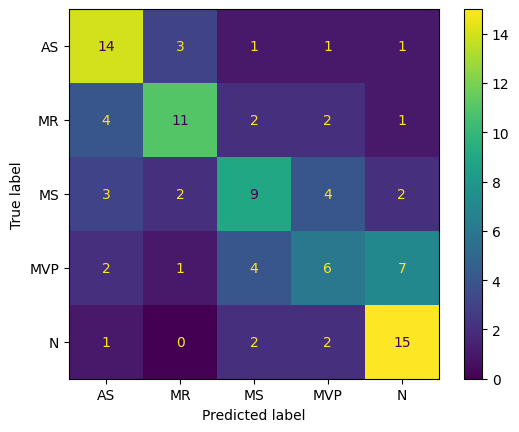

Accuracy : [0.84 0.85 0.8  0.77 0.84] mean:  0.8200000000000001
Precision : [0.58333333 0.64705882 0.5        0.4        0.57692308] mean:  0.5414630467571644
Sensitivity : [0.7  0.55 0.45 0.3  0.75] mean:  0.55
Specificity : [0.875  0.925  0.8875 0.8875 0.8625] mean:  0.8875
f1_score: [0.63636364 0.59459459 0.47368421 0.34285714 0.65217391] mean:  0.5399346994770337



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb4L2.csv_3.h5
4/4 [==============================] - 0s 4ms/step


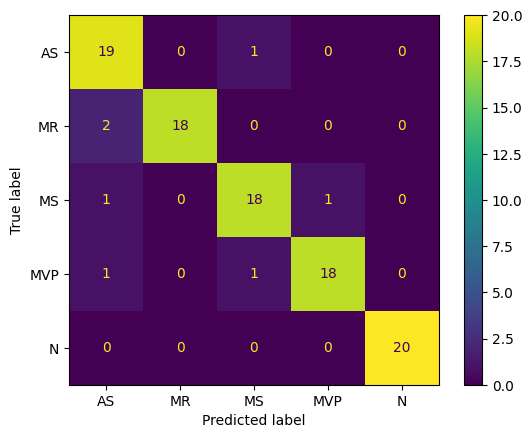

Accuracy : [0.95 0.98 0.96 0.97 1.  ] mean:  0.9719999999999999
Precision : [0.82608696 1.         0.9        0.94736842 1.        ] mean:  0.9346910755148741
Sensitivity : [0.95 0.9  0.9  0.9  1.  ] mean:  0.93
Specificity : [0.95   1.     0.975  0.9875 1.    ] mean:  0.9824999999999999
f1_score: [0.88372093 0.94736842 0.9        0.92307692 1.        ] mean:  0.9308332548724225



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb4L3.csv_2.h5
4/4 [==============================] - 0s 5ms/step


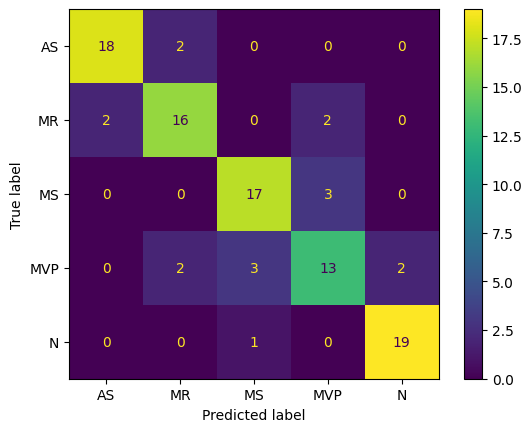

Accuracy : [0.96 0.92 0.93 0.88 0.97] mean:  0.932
Precision : [0.9        0.8        0.80952381 0.72222222 0.9047619 ] mean:  0.8273015873015874
Sensitivity : [0.9  0.8  0.85 0.65 0.95] mean:  0.8300000000000001
Specificity : [0.975  0.95   0.95   0.9375 0.975 ] mean:  0.9574999999999999
f1_score: [0.9        0.8        0.82926829 0.68421053 0.92682927] mean:  0.8280616174582798



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb4L4.csv_2.h5
4/4 [==============================] - 0s 5ms/step


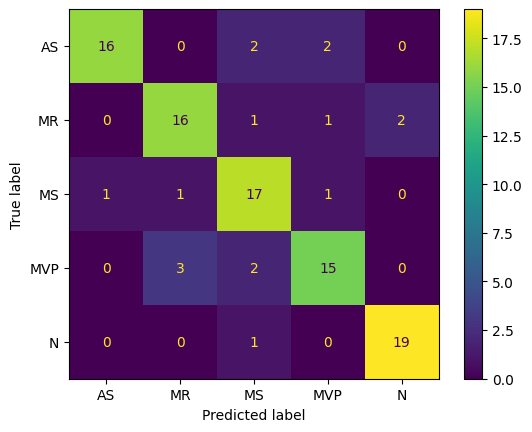

Accuracy : [0.95 0.92 0.91 0.91 0.97] mean:  0.932
Precision : [0.94117647 0.8        0.73913043 0.78947368 0.9047619 ] mean:  0.834908498868655
Sensitivity : [0.8  0.8  0.85 0.75 0.95] mean:  0.8300000000000001
Specificity : [0.9875 0.95   0.925  0.95   0.975 ] mean:  0.9574999999999999
f1_score: [0.86486486 0.8        0.79069767 0.76923077 0.92682927] mean:  0.8303245153613844



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb4L5.csv_2.h5
4/4 [==============================] - 0s 5ms/step


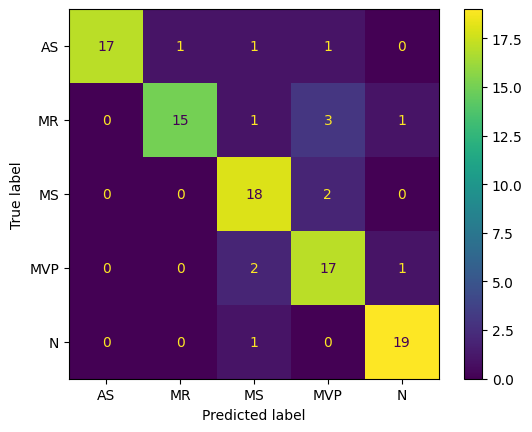

Accuracy : [0.97 0.94 0.93 0.91 0.97] mean:  0.944
Precision : [1.         0.9375     0.7826087  0.73913043 0.9047619 ] mean:  0.8728002070393375
Sensitivity : [0.85 0.75 0.9  0.85 0.95] mean:  0.86
Specificity : [1.     0.9875 0.9375 0.925  0.975 ] mean:  0.9649999999999999
f1_score: [0.91891892 0.83333333 0.8372093  0.79069767 0.92682927] mean:  0.8613976994578243



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb4L6.csv_2.h5
4/4 [==============================] - 0s 4ms/step


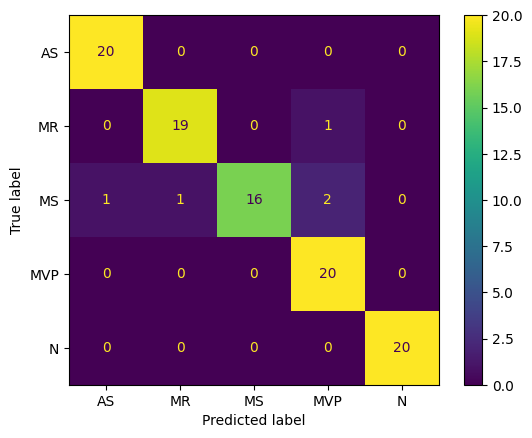

Accuracy : [0.99 0.98 0.96 0.97 1.  ] mean:  0.9799999999999999
Precision : [0.95238095 0.95       1.         0.86956522 1.        ] mean:  0.9543892339544513
Sensitivity : [1.   0.95 0.8  1.   1.  ] mean:  0.95
Specificity : [0.9875 0.9875 1.     0.9625 1.    ] mean:  0.9875
f1_score: [0.97560976 0.95       0.88888889 0.93023256 1.        ] mean:  0.9489462406251971



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb4L7.csv_5.h5
4/4 [==============================] - 0s 4ms/step


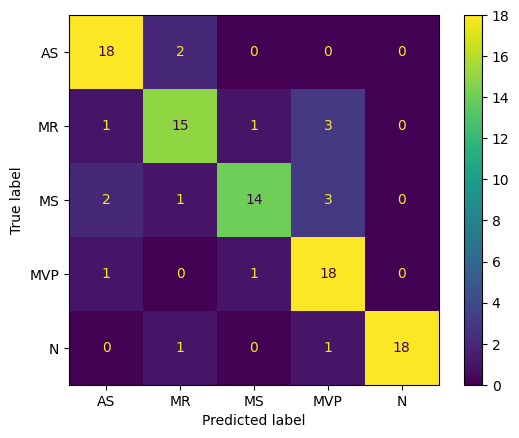

Accuracy : [0.94 0.91 0.92 0.91 0.98] mean:  0.932
Precision : [0.81818182 0.78947368 0.875      0.72       1.        ] mean:  0.8405311004784689
Sensitivity : [0.9  0.75 0.7  0.9  0.9 ] mean:  0.8299999999999998
Specificity : [0.95   0.95   0.975  0.9125 1.    ] mean:  0.9574999999999999
f1_score: [0.85714286 0.76923077 0.77777778 0.8        0.94736842] mean:  0.8303039650408071



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb4L8.csv_2.h5
4/4 [==============================] - 0s 5ms/step


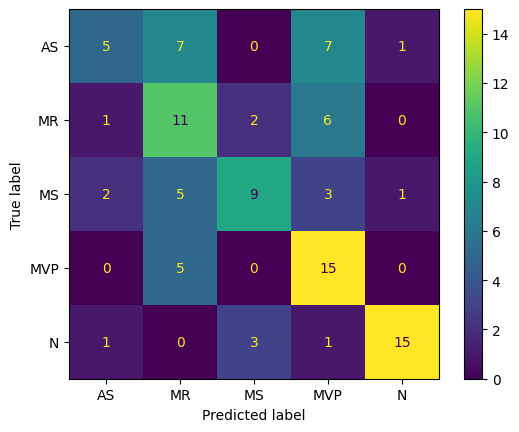

Accuracy : [0.81 0.74 0.84 0.78 0.93] mean:  0.82
Precision : [0.55555556 0.39285714 0.64285714 0.46875    0.88235294] mean:  0.5884745564892624
Sensitivity : [0.25 0.55 0.45 0.75 0.75] mean:  0.55
Specificity : [0.95   0.7875 0.9375 0.7875 0.975 ] mean:  0.8875
f1_score: [0.34482759 0.45833333 0.52941176 0.57692308 0.81081081] mean:  0.544061314396



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb4L9.csv_5.h5
4/4 [==============================] - 0s 5ms/step


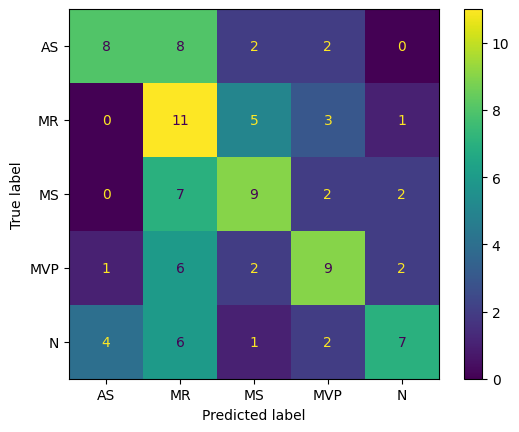

Accuracy : [0.83 0.64 0.79 0.8  0.82] mean:  0.7759999999999999
Precision : [0.61538462 0.28947368 0.47368421 0.5        0.58333333] mean:  0.4923751686909582
Sensitivity : [0.4  0.55 0.45 0.45 0.35] mean:  0.44000000000000006
Specificity : [0.9375 0.6625 0.875  0.8875 0.9375] mean:  0.86
f1_score: [0.48484848 0.37931034 0.46153846 0.47368421 0.4375    ] mean:  0.4473763003481698



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb4L10.csv_1.h5
4/4 [==============================] - 0s 5ms/step


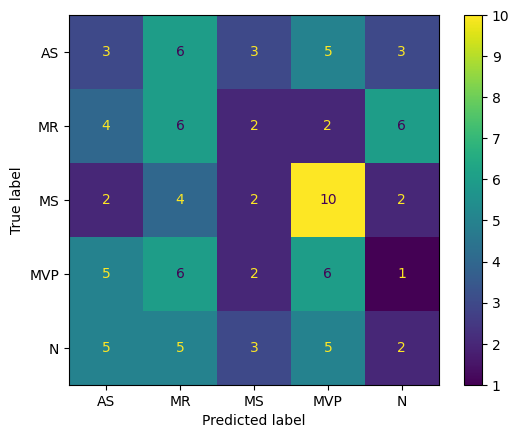

Accuracy : [0.67 0.65 0.72 0.64 0.7 ] mean:  0.6759999999999999
Precision : [0.15789474 0.22222222 0.16666667 0.21428571 0.14285714] mean:  0.18078529657477027
Sensitivity : [0.15 0.3  0.1  0.3  0.1 ] mean:  0.18999999999999997
Specificity : [0.8    0.7375 0.875  0.725  0.85  ] mean:  0.7975000000000001
f1_score: [0.15384615 0.25531915 0.125      0.25       0.11764706] mean:  0.1803624723211707



Accuracy All : [0.8200000000000001, 0.9719999999999999, 0.932, 0.932, 0.944, 0.9799999999999999, 0.932, 0.82, 0.7759999999999999, 0.6759999999999999]
Precision All : [0.5414630467571644, 0.9346910755148741, 0.8273015873015874, 0.834908498868655, 0.8728002070393375, 0.9543892339544513, 0.8405311004784689, 0.5884745564892624, 0.4923751686909582, 0.18078529657477027]
Sensitivity All : [0.55, 0.93, 0.8300000000000001, 0.8300000000000001, 0.86, 0.95, 0.8299999999999998, 0.55, 0.44000000000000006, 0.18999999999999997]
Specificity All : [0.8875, 0.9824999999999999, 0.9574999999999999, 0.957499999999

In [13]:
testingVHD(a4, 4)

Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb5L1.csv_5.h5


4/4 [==============================] - 0s 4ms/step


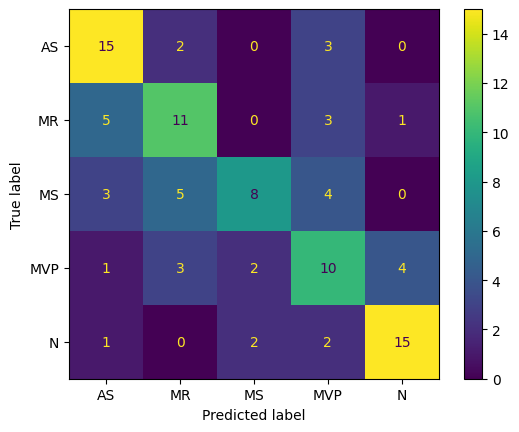

Accuracy : [0.85 0.81 0.84 0.78 0.9 ] mean:  0.8360000000000001
Precision : [0.6        0.52380952 0.66666667 0.45454545 0.75      ] mean:  0.599004329004329
Sensitivity : [0.75 0.55 0.4  0.5  0.75] mean:  0.5900000000000001
Specificity : [0.875  0.875  0.95   0.85   0.9375] mean:  0.8975000000000002
f1_score: [0.66666667 0.53658537 0.5        0.47619048 0.75      ] mean:  0.5858885017421602



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb5L2.csv_4.h5
4/4 [==============================] - 0s 5ms/step


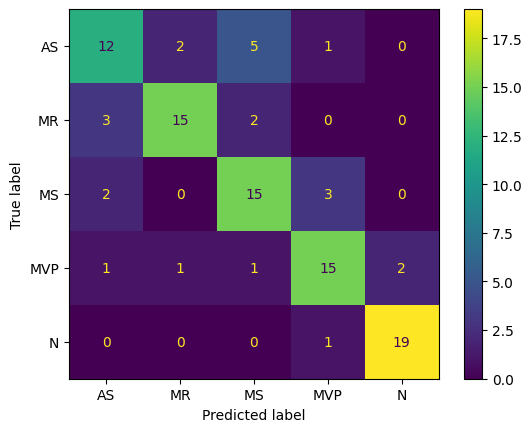

Accuracy : [0.86 0.92 0.87 0.9  0.97] mean:  0.9039999999999999
Precision : [0.66666667 0.83333333 0.65217391 0.75       0.9047619 ] mean:  0.7613871635610766
Sensitivity : [0.6  0.75 0.75 0.75 0.95] mean:  0.76
Specificity : [0.925  0.9625 0.9    0.9375 0.975 ] mean:  0.9400000000000001
f1_score: [0.63157895 0.78947368 0.69767442 0.75       0.92682927] mean:  0.7591112636952563



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb5L3.csv_3.h5
4/4 [==============================] - 0s 4ms/step


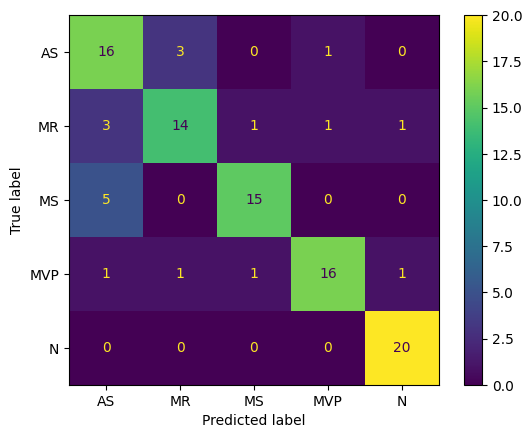

Accuracy : [0.87 0.9  0.93 0.94 0.98] mean:  0.924
Precision : [0.64       0.77777778 0.88235294 0.88888889 0.90909091] mean:  0.8196221033868092
Sensitivity : [0.8  0.7  0.75 0.8  1.  ] mean:  0.8099999999999999
Specificity : [0.8875 0.95   0.975  0.975  0.975 ] mean:  0.9525
f1_score: [0.71111111 0.73684211 0.81081081 0.84210526 0.95238095] mean:  0.8106500485447853



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb5L4.csv_5.h5
4/4 [==============================] - 0s 5ms/step


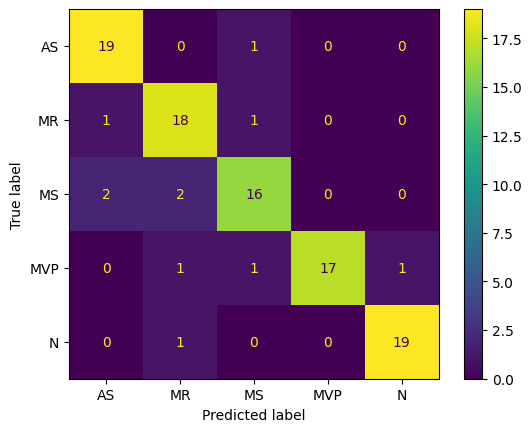

Accuracy : [0.96 0.94 0.93 0.97 0.98] mean:  0.9559999999999998
Precision : [0.86363636 0.81818182 0.84210526 1.         0.95      ] mean:  0.8947846889952153
Sensitivity : [0.95 0.9  0.8  0.85 0.95] mean:  0.89
Specificity : [0.9625 0.95   0.9625 1.     0.9875] mean:  0.9724999999999999
f1_score: [0.9047619  0.85714286 0.82051282 0.91891892 0.95      ] mean:  0.8902673002673002



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb5L5.csv_2.h5
4/4 [==============================] - 0s 5ms/step


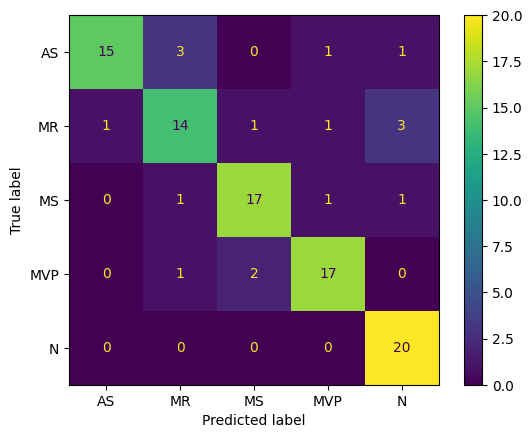

Accuracy : [0.94 0.89 0.94 0.94 0.95] mean:  0.932
Precision : [0.9375     0.73684211 0.85       0.85       0.8       ] mean:  0.8348684210526317
Sensitivity : [0.75 0.7  0.85 0.85 1.  ] mean:  0.8300000000000001
Specificity : [0.9875 0.9375 0.9625 0.9625 0.9375] mean:  0.9574999999999999
f1_score: [0.83333333 0.71794872 0.85       0.85       0.88888889] mean:  0.8280341880341882



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb5L6.csv_5.h5
4/4 [==============================] - 0s 5ms/step


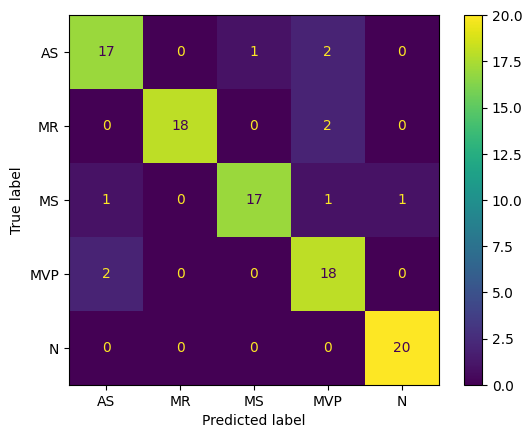

Accuracy : [0.94 0.98 0.96 0.93 0.99] mean:  0.96
Precision : [0.85       1.         0.94444444 0.7826087  0.95238095] mean:  0.9058868184955141
Sensitivity : [0.85 0.9  0.85 0.9  1.  ] mean:  0.9
Specificity : [0.9625 1.     0.9875 0.9375 0.9875] mean:  0.975
f1_score: [0.85       0.94736842 0.89473684 0.8372093  0.97560976] mean:  0.9009848643162075



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb5L7.csv_3.h5
4/4 [==============================] - 0s 4ms/step


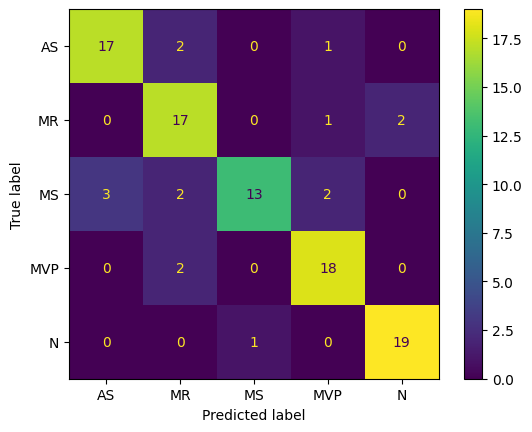

Accuracy : [0.94 0.91 0.92 0.94 0.97] mean:  0.9359999999999999
Precision : [0.85       0.73913043 0.92857143 0.81818182 0.9047619 ] mean:  0.8481291172595521
Sensitivity : [0.85 0.85 0.65 0.9  0.95] mean:  0.8400000000000001
Specificity : [0.9625 0.925  0.9875 0.95   0.975 ] mean:  0.96
f1_score: [0.85       0.79069767 0.76470588 0.85714286 0.92682927] mean:  0.8378751364414171



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb5L8.csv_3.h5
4/4 [==============================] - 0s 5ms/step


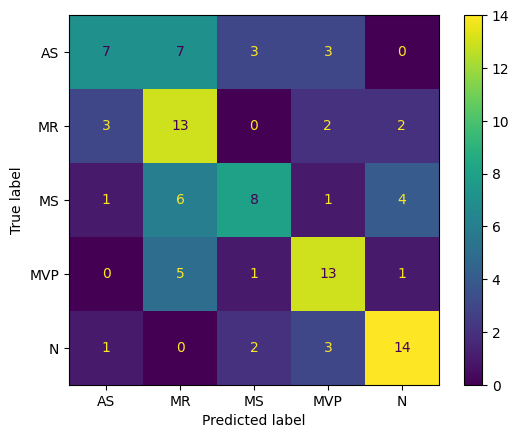

Accuracy : [0.82 0.75 0.82 0.84 0.87] mean:  0.82
Precision : [0.58333333 0.41935484 0.57142857 0.59090909 0.66666667] mean:  0.5663385002094679
Sensitivity : [0.35 0.65 0.4  0.65 0.7 ] mean:  0.55
Specificity : [0.9375 0.775  0.925  0.8875 0.9125] mean:  0.8875
f1_score: [0.4375     0.50980392 0.47058824 0.61904762 0.68292683] mean:  0.5439733210357314



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb5L9.csv_2.h5
4/4 [==============================] - 0s 5ms/step


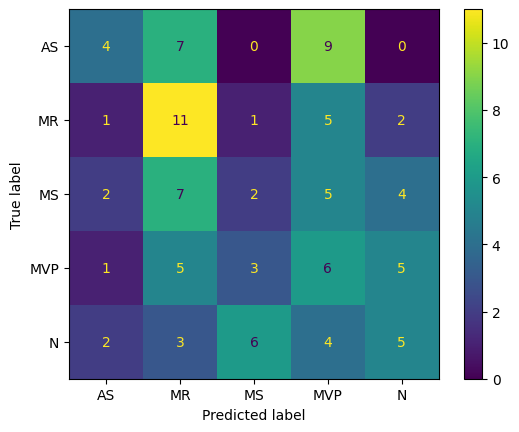

Accuracy : [0.78 0.69 0.72 0.63 0.74] mean:  0.712
Precision : [0.4        0.33333333 0.16666667 0.20689655 0.3125    ] mean:  0.2838793103448276
Sensitivity : [0.2  0.55 0.1  0.3  0.25] mean:  0.27999999999999997
Specificity : [0.925  0.725  0.875  0.7125 0.8625] mean:  0.82
f1_score: [0.26666667 0.41509434 0.125      0.24489796 0.27777778] mean:  0.2658873486501519



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb5L10.csv_3.h5
4/4 [==============================] - 0s 5ms/step


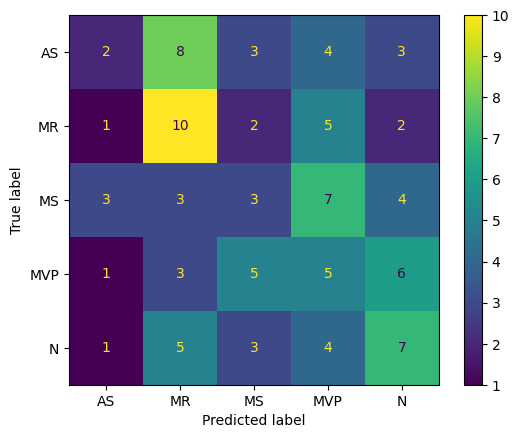

Accuracy : [0.76 0.71 0.7  0.65 0.72] mean:  0.708
Precision : [0.25       0.34482759 0.1875     0.2        0.31818182] mean:  0.26010188087774294
Sensitivity : [0.1  0.5  0.15 0.25 0.35] mean:  0.27
Specificity : [0.925  0.7625 0.8375 0.75   0.8125] mean:  0.8175000000000001
f1_score: [0.14285714 0.40816327 0.16666667 0.22222222 0.33333333] mean:  0.25464852607709754



Accuracy All : [0.8360000000000001, 0.9039999999999999, 0.924, 0.9559999999999998, 0.932, 0.96, 0.9359999999999999, 0.82, 0.712, 0.708]
Precision All : [0.599004329004329, 0.7613871635610766, 0.8196221033868092, 0.8947846889952153, 0.8348684210526317, 0.9058868184955141, 0.8481291172595521, 0.5663385002094679, 0.2838793103448276, 0.26010188087774294]
Sensitivity All : [0.5900000000000001, 0.76, 0.8099999999999999, 0.89, 0.8300000000000001, 0.9, 0.8400000000000001, 0.55, 0.27999999999999997, 0.27]
Specificity All : [0.8975000000000002, 0.9400000000000001, 0.9525, 0.9724999999999999, 0.9574999999999999, 0.975, 0.96, 0.88

In [14]:
testingVHD(a5, 5)

Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb6L1.csv_3.h5
4/4 [==============================] - 0s 5ms/step


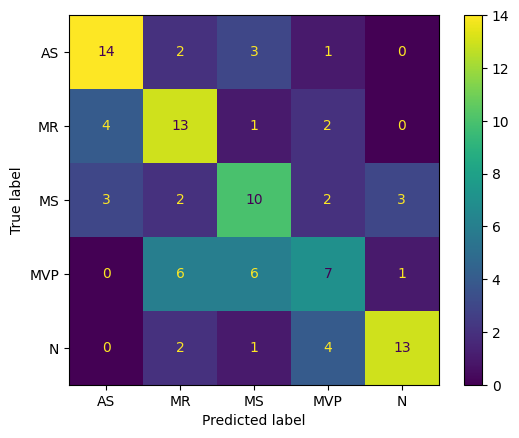

Accuracy : [0.87 0.81 0.79 0.78 0.89] mean:  0.828
Precision : [0.66666667 0.52       0.47619048 0.4375     0.76470588] mean:  0.5730126050420168
Sensitivity : [0.7  0.65 0.5  0.35 0.65] mean:  0.5700000000000001
Specificity : [0.9125 0.85   0.8625 0.8875 0.95  ] mean:  0.8925000000000001
f1_score: [0.68292683 0.57777778 0.48780488 0.38888889 0.7027027 ] mean:  0.5680202153372884



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb6L2.csv_2.h5
4/4 [==============================] - 0s 5ms/step


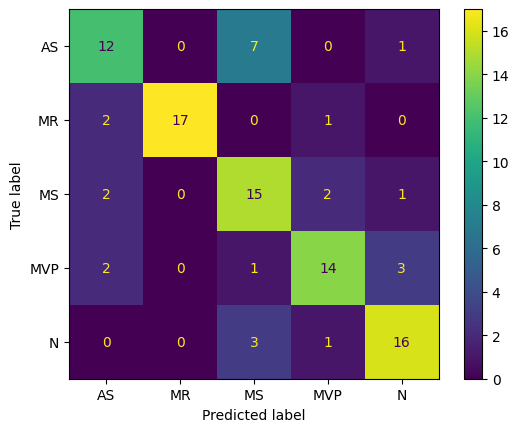

Accuracy : [0.86 0.97 0.84 0.9  0.91] mean:  0.8959999999999999
Precision : [0.66666667 1.         0.57692308 0.77777778 0.76190476] mean:  0.7566544566544566
Sensitivity : [0.6  0.85 0.75 0.7  0.8 ] mean:  0.74
Specificity : [0.925  1.     0.8625 0.95   0.9375] mean:  0.9349999999999999
f1_score: [0.63157895 0.91891892 0.65217391 0.73684211 0.7804878 ] mean:  0.7440003378944049



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb6L3.csv_5.h5
4/4 [==============================] - 0s 5ms/step


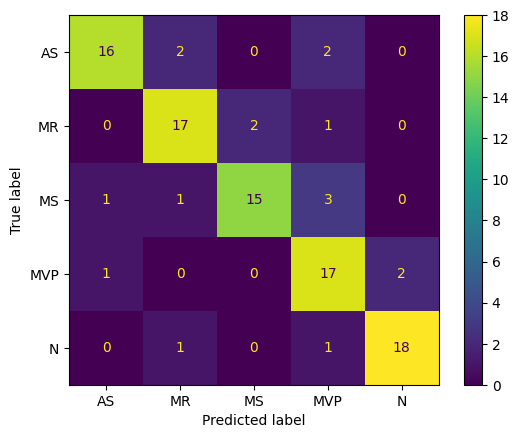

Accuracy : [0.94 0.93 0.93 0.9  0.96] mean:  0.932
Precision : [0.88888889 0.80952381 0.88235294 0.70833333 0.9       ] mean:  0.8378197945845004
Sensitivity : [0.8  0.85 0.75 0.85 0.9 ] mean:  0.8300000000000001
Specificity : [0.975  0.95   0.975  0.9125 0.975 ] mean:  0.9574999999999999
f1_score: [0.84210526 0.82926829 0.81081081 0.77272727 0.9       ] mean:  0.8309823278757811



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb6L4.csv_2.h5
4/4 [==============================] - 0s 4ms/step


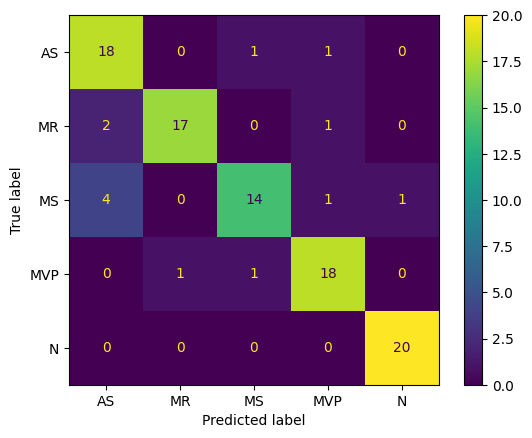

Accuracy : [0.92 0.96 0.92 0.95 0.99] mean:  0.9480000000000001
Precision : [0.75       0.94444444 0.875      0.85714286 0.95238095] mean:  0.8757936507936508
Sensitivity : [0.9  0.85 0.7  0.9  1.  ] mean:  0.8699999999999999
Specificity : [0.925  0.9875 0.975  0.9625 0.9875] mean:  0.9675
f1_score: [0.81818182 0.89473684 0.77777778 0.87804878 0.97560976] mean:  0.8688709949300449



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb6L5.csv_5.h5
4/4 [==============================] - 0s 5ms/step


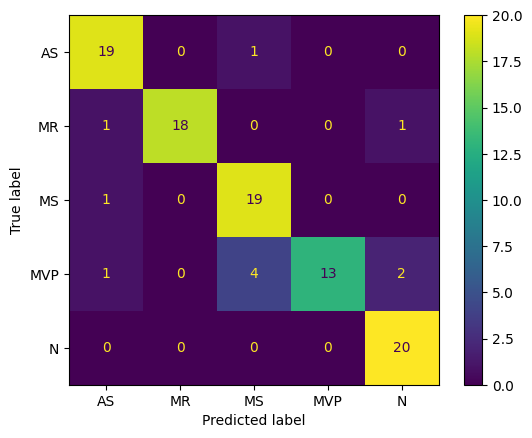

Accuracy : [0.96 0.98 0.94 0.93 0.97] mean:  0.9560000000000001
Precision : [0.86363636 1.         0.79166667 1.         0.86956522] mean:  0.9049736495388669
Sensitivity : [0.95 0.9  0.95 0.65 1.  ] mean:  0.8899999999999999
Specificity : [0.9625 1.     0.9375 1.     0.9625] mean:  0.9724999999999999
f1_score: [0.9047619  0.94736842 0.86363636 0.78787879 0.93023256] mean:  0.8867756070938446



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb6L6.csv_2.h5
4/4 [==============================] - 0s 5ms/step


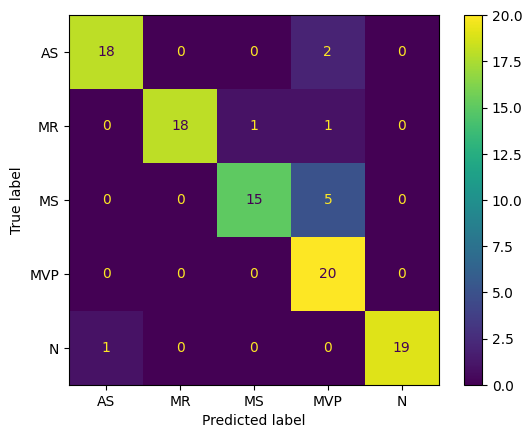

Accuracy : [0.97 0.98 0.94 0.92 0.99] mean:  0.96
Precision : [0.94736842 1.         0.9375     0.71428571 1.        ] mean:  0.919830827067669
Sensitivity : [0.9  0.9  0.75 1.   0.95] mean:  0.9
Specificity : [0.9875 1.     0.9875 0.9    1.    ] mean:  0.975
f1_score: [0.92307692 0.94736842 0.83333333 0.83333333 0.97435897] mean:  0.9022941970310392



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb6L7.csv_2.h5
4/4 [==============================] - 0s 5ms/step


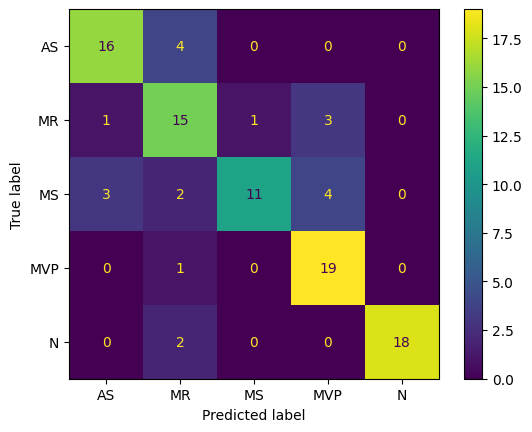

Accuracy : [0.92 0.86 0.9  0.92 0.98] mean:  0.916
Precision : [0.8        0.625      0.91666667 0.73076923 1.        ] mean:  0.8144871794871795
Sensitivity : [0.8  0.75 0.55 0.95 0.9 ] mean:  0.7899999999999999
Specificity : [0.95   0.8875 0.9875 0.9125 1.    ] mean:  0.9475000000000001
f1_score: [0.8        0.68181818 0.6875     0.82608696 0.94736842] mean:  0.7885547118785106



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb6L8.csv_5.h5
4/4 [==============================] - 0s 5ms/step


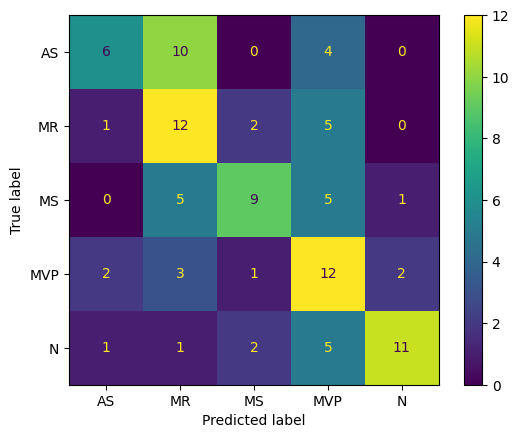

Accuracy : [0.82 0.73 0.84 0.73 0.88] mean:  0.7999999999999999
Precision : [0.6        0.38709677 0.64285714 0.38709677 0.78571429] mean:  0.5605529953917051
Sensitivity : [0.3  0.6  0.45 0.6  0.55] mean:  0.5
Specificity : [0.95   0.7625 0.9375 0.7625 0.9625] mean:  0.875
f1_score: [0.4        0.47058824 0.52941176 0.47058824 0.64705882] mean:  0.5035294117647059



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb6L9.csv_2.h5
4/4 [==============================] - 0s 4ms/step


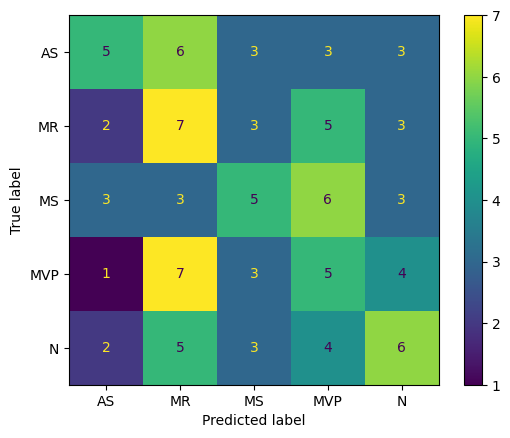

Accuracy : [0.77 0.66 0.73 0.67 0.73] mean:  0.712
Precision : [0.38461538 0.25       0.29411765 0.2173913  0.31578947] mean:  0.29238276194124896
Sensitivity : [0.25 0.35 0.25 0.25 0.3 ] mean:  0.28
Specificity : [0.9    0.7375 0.85   0.775  0.8375] mean:  0.8200000000000001
f1_score: [0.3030303  0.29166667 0.27027027 0.23255814 0.30769231] mean:  0.28104353743888627



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb6L10.csv_3.h5
4/4 [==============================] - 0s 5ms/step


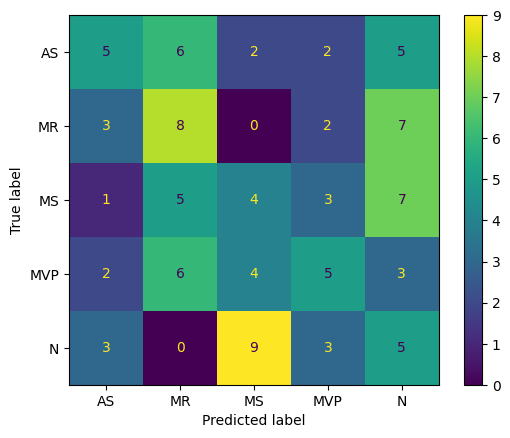

Accuracy : [0.76 0.71 0.69 0.75 0.63] mean:  0.708
Precision : [0.35714286 0.32       0.21052632 0.33333333 0.18518519] mean:  0.28123753829016984
Sensitivity : [0.25 0.4  0.2  0.25 0.25] mean:  0.27
Specificity : [0.8875 0.7875 0.8125 0.875  0.725 ] mean:  0.8174999999999999
f1_score: [0.29411765 0.35555556 0.20512821 0.28571429 0.21276596] mean:  0.2706563301807357



Accuracy All : [0.828, 0.8959999999999999, 0.932, 0.9480000000000001, 0.9560000000000001, 0.96, 0.916, 0.7999999999999999, 0.712, 0.708]
Precision All : [0.5730126050420168, 0.7566544566544566, 0.8378197945845004, 0.8757936507936508, 0.9049736495388669, 0.919830827067669, 0.8144871794871795, 0.5605529953917051, 0.29238276194124896, 0.28123753829016984]
Sensitivity All : [0.5700000000000001, 0.74, 0.8300000000000001, 0.8699999999999999, 0.8899999999999999, 0.9, 0.7899999999999999, 0.5, 0.28, 0.27]
Specificity All : [0.8925000000000001, 0.9349999999999999, 0.9574999999999999, 0.9675, 0.9724999999999999, 0.975, 0.947500000

In [15]:
testingVHD(a6, 6)

Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb7L1.csv_5.h5


4/4 [==============================] - 0s 4ms/step


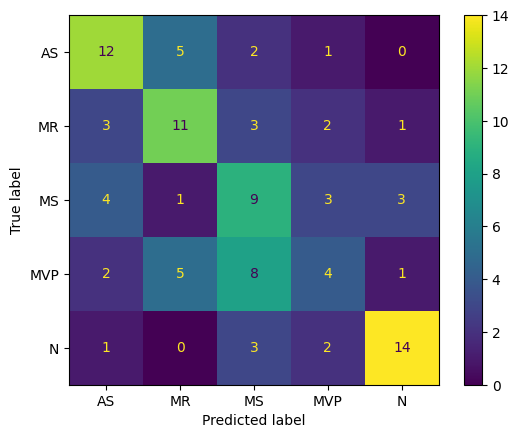

Accuracy : [0.82 0.8  0.73 0.76 0.89] mean:  0.8
Precision : [0.54545455 0.5        0.36       0.33333333 0.73684211] mean:  0.49512599681020725
Sensitivity : [0.6  0.55 0.45 0.2  0.7 ] mean:  0.5
Specificity : [0.875  0.8625 0.8    0.9    0.9375] mean:  0.875
f1_score: [0.57142857 0.52380952 0.4        0.25       0.71794872] mean:  0.4926373626373626



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb7L2.csv_2.h5
4/4 [==============================] - 0s 4ms/step


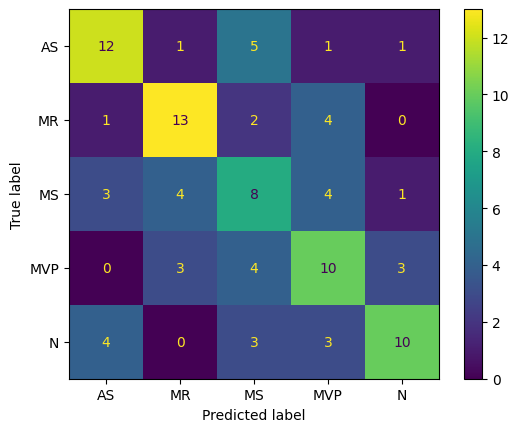

Accuracy : [0.84 0.85 0.74 0.78 0.85] mean:  0.8119999999999999
Precision : [0.6        0.61904762 0.36363636 0.45454545 0.66666667] mean:  0.5407792207792208
Sensitivity : [0.6  0.65 0.4  0.5  0.5 ] mean:  0.53
Specificity : [0.9    0.9    0.825  0.85   0.9375] mean:  0.8825
f1_score: [0.6        0.63414634 0.38095238 0.47619048 0.57142857] mean:  0.5325435540069686



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb7L3.csv_2.h5
4/4 [==============================] - 0s 5ms/step


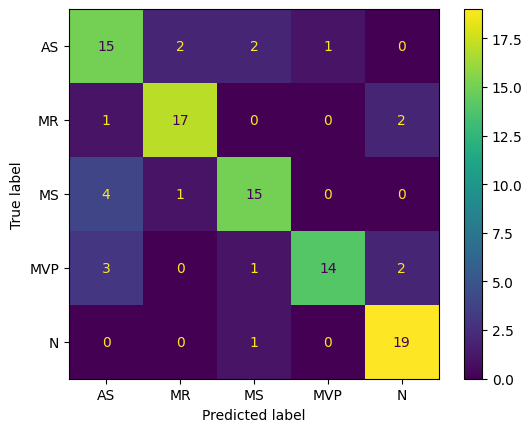

Accuracy : [0.87 0.94 0.91 0.93 0.95] mean:  0.9200000000000002
Precision : [0.65217391 0.85       0.78947368 0.93333333 0.82608696] mean:  0.8102135774218155
Sensitivity : [0.75 0.85 0.75 0.7  0.95] mean:  0.8
Specificity : [0.9    0.9625 0.95   0.9875 0.95  ] mean:  0.95
f1_score: [0.69767442 0.85       0.76923077 0.8        0.88372093] mean:  0.8001252236135956



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb7L4.csv_2.h5
4/4 [==============================] - 0s 5ms/step


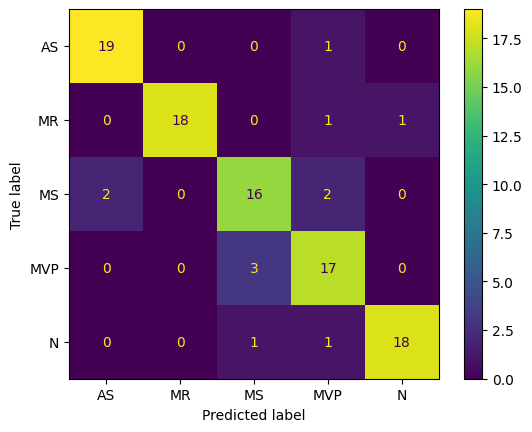

Accuracy : [0.97 0.98 0.92 0.92 0.97] mean:  0.952
Precision : [0.9047619  1.         0.8        0.77272727 0.94736842] mean:  0.8849715197083619
Sensitivity : [0.95 0.9  0.8  0.85 0.9 ] mean:  0.8800000000000001
Specificity : [0.975  1.     0.95   0.9375 0.9875] mean:  0.97
f1_score: [0.92682927 0.94736842 0.8        0.80952381 0.92307692] mean:  0.8813596843892094



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb7L5.csv_2.h5
4/4 [==============================] - 0s 5ms/step


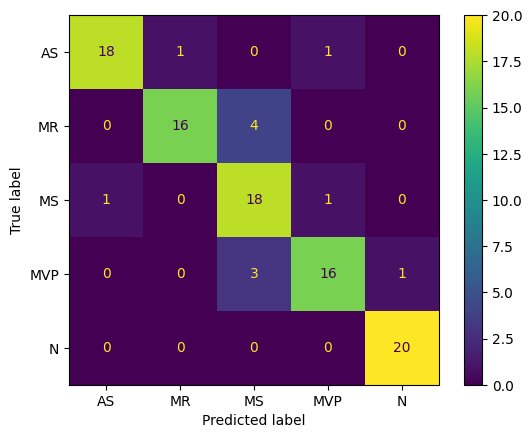

Accuracy : [0.97 0.95 0.91 0.94 0.99] mean:  0.952
Precision : [0.94736842 0.94117647 0.72       0.88888889 0.95238095] mean:  0.8899629465821416
Sensitivity : [0.9 0.8 0.9 0.8 1. ] mean:  0.8800000000000001
Specificity : [0.9875 0.9875 0.9125 0.975  0.9875] mean:  0.9700000000000001
f1_score: [0.92307692 0.86486486 0.8        0.84210526 0.97560976] mean:  0.8811313614394486



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb7L6.csv_2.h5
4/4 [==============================] - 0s 4ms/step


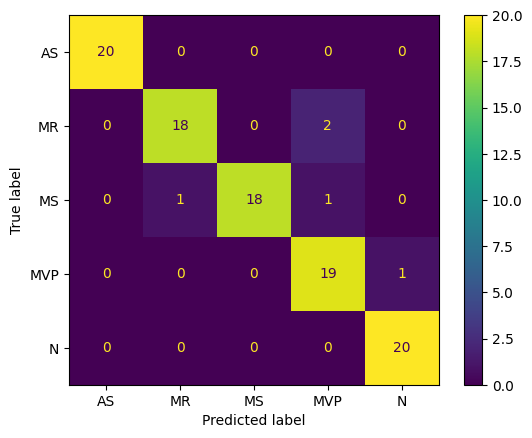

Accuracy : [1.   0.97 0.98 0.96 0.99] mean:  0.9800000000000001
Precision : [1.         0.94736842 1.         0.86363636 0.95238095] mean:  0.9526771474139896
Sensitivity : [1.   0.9  0.9  0.95 1.  ] mean:  0.95
Specificity : [1.     0.9875 1.     0.9625 0.9875] mean:  0.9875
f1_score: [1.         0.92307692 0.94736842 0.9047619  0.97560976] mean:  0.950163400997804



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb7L7.csv_5.h5
4/4 [==============================] - 0s 5ms/step


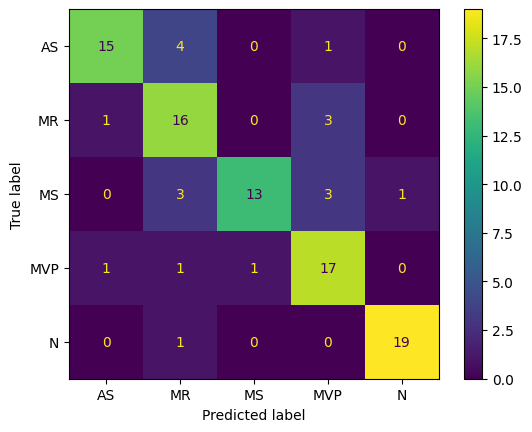

Accuracy : [0.93 0.87 0.92 0.9  0.98] mean:  0.9199999999999999
Precision : [0.88235294 0.64       0.92857143 0.70833333 0.95      ] mean:  0.8218515406162465
Sensitivity : [0.75 0.8  0.65 0.85 0.95] mean:  0.8
Specificity : [0.975  0.8875 0.9875 0.9125 0.9875] mean:  0.95
f1_score: [0.81081081 0.71111111 0.76470588 0.77272727 0.95      ] mean:  0.8018710154004272



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb7L8.csv_2.h5
4/4 [==============================] - 0s 6ms/step


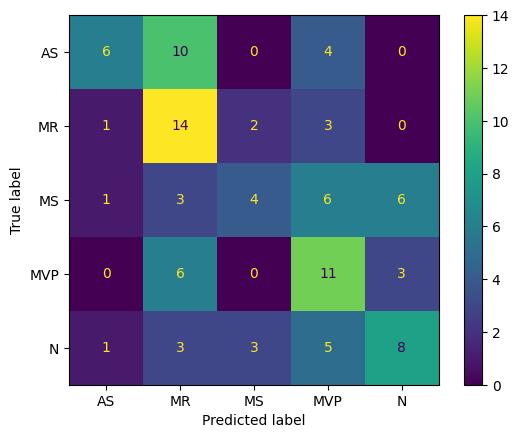

Accuracy : [0.83 0.72 0.79 0.73 0.79] mean:  0.772
Precision : [0.66666667 0.38888889 0.44444444 0.37931034 0.47058824] mean:  0.4699797160243408
Sensitivity : [0.3  0.7  0.2  0.55 0.4 ] mean:  0.43
Specificity : [0.9625 0.725  0.9375 0.775  0.8875] mean:  0.8574999999999999
f1_score: [0.4137931  0.5        0.27586207 0.44897959 0.43243243] mean:  0.41421343933659205



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb7L9.csv_1.h5
4/4 [==============================] - 0s 5ms/step


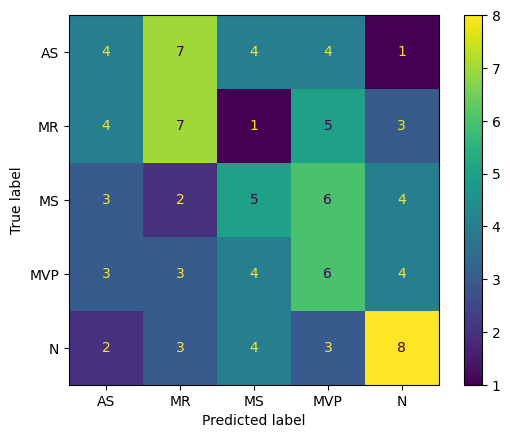

Accuracy : [0.72 0.72 0.72 0.68 0.76] mean:  0.7200000000000001
Precision : [0.25       0.31818182 0.27777778 0.25       0.4       ] mean:  0.2991919191919192
Sensitivity : [0.2  0.35 0.25 0.3  0.4 ] mean:  0.3
Specificity : [0.85   0.8125 0.8375 0.775  0.85  ] mean:  0.825
f1_score: [0.22222222 0.33333333 0.26315789 0.27272727 0.4       ] mean:  0.2982881446039341



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb7L10.csv_1.h5
4/4 [==============================] - 0s 5ms/step


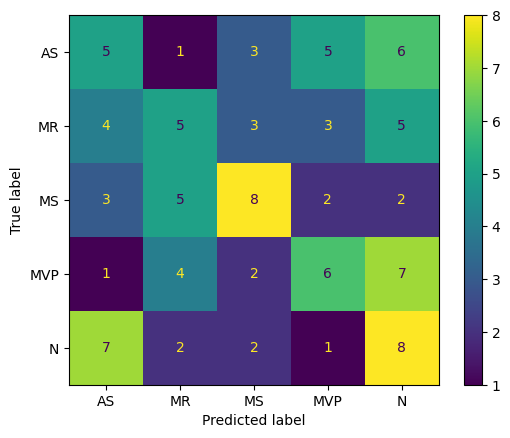

Accuracy : [0.7  0.73 0.78 0.75 0.68] mean:  0.728
Precision : [0.25       0.29411765 0.44444444 0.35294118 0.28571429] mean:  0.3254435107376284
Sensitivity : [0.25 0.25 0.4  0.3  0.4 ] mean:  0.32
Specificity : [0.8125 0.85   0.875  0.8625 0.75  ] mean:  0.8300000000000001
f1_score: [0.25       0.27027027 0.42105263 0.32432432 0.33333333] mean:  0.319796111901375



Accuracy All : [0.8, 0.8119999999999999, 0.9200000000000002, 0.952, 0.952, 0.9800000000000001, 0.9199999999999999, 0.772, 0.7200000000000001, 0.728]
Precision All : [0.49512599681020725, 0.5407792207792208, 0.8102135774218155, 0.8849715197083619, 0.8899629465821416, 0.9526771474139896, 0.8218515406162465, 0.4699797160243408, 0.2991919191919192, 0.3254435107376284]
Sensitivity All : [0.5, 0.53, 0.8, 0.8800000000000001, 0.8800000000000001, 0.95, 0.8, 0.43, 0.3, 0.32]
Specificity All : [0.875, 0.8825, 0.95, 0.97, 0.9700000000000001, 0.9875, 0.95, 0.8574999999999999, 0.825, 0.8300000000000001]
f1_score All : [0.49263736263736

In [16]:
testingVHD(a7, 7)

Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb8L1.csv_3.h5


4/4 [==============================] - 0s 5ms/step


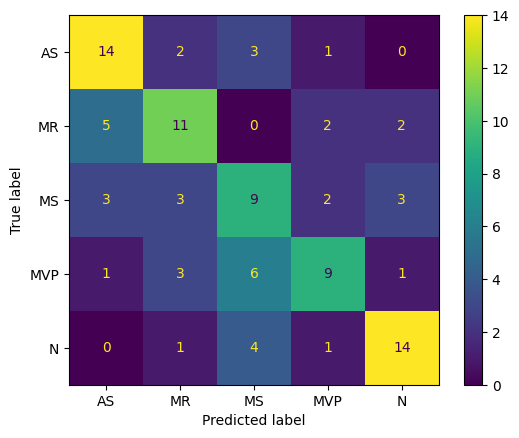

Accuracy : [0.85 0.82 0.76 0.83 0.88] mean:  0.828
Precision : [0.60869565 0.55       0.40909091 0.6        0.7       ] mean:  0.5735573122529644
Sensitivity : [0.7  0.55 0.45 0.45 0.7 ] mean:  0.57
Specificity : [0.8875 0.8875 0.8375 0.925  0.925 ] mean:  0.8924999999999998
f1_score: [0.65116279 0.55       0.42857143 0.51428571 0.7       ] mean:  0.5688039867109635



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb8L2.csv_5.h5
4/4 [==============================] - 0s 4ms/step


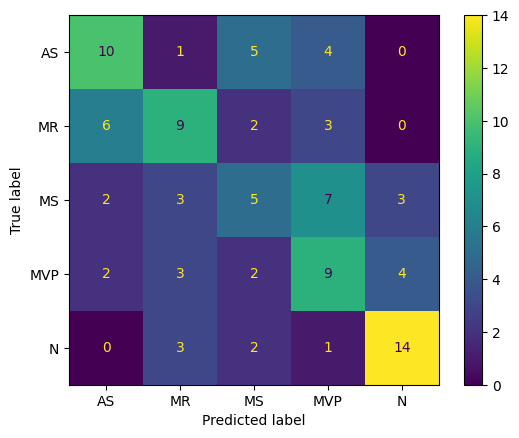

Accuracy : [0.8  0.79 0.74 0.74 0.87] mean:  0.788
Precision : [0.5        0.47368421 0.3125     0.375      0.66666667] mean:  0.46557017543859647
Sensitivity : [0.5  0.45 0.25 0.45 0.7 ] mean:  0.4699999999999999
Specificity : [0.875  0.875  0.8625 0.8125 0.9125] mean:  0.8674999999999999
f1_score: [0.5        0.46153846 0.27777778 0.40909091 0.68292683] mean:  0.4662667955350882



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb8L3.csv_5.h5
4/4 [==============================] - 0s 5ms/step


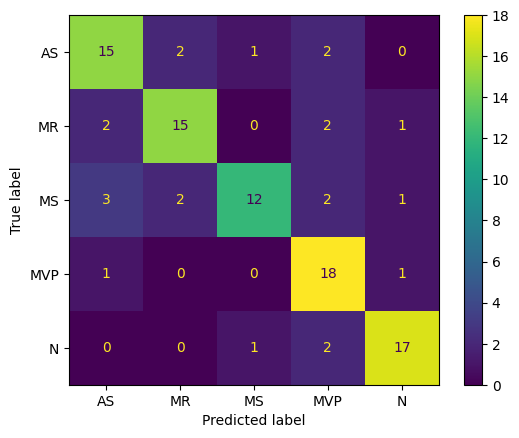

Accuracy : [0.89 0.91 0.9  0.9  0.94] mean:  0.908
Precision : [0.71428571 0.78947368 0.85714286 0.69230769 0.85      ] mean:  0.780641989589358
Sensitivity : [0.75 0.75 0.6  0.9  0.85] mean:  0.77
Specificity : [0.925  0.95   0.975  0.9    0.9625] mean:  0.9425000000000001
f1_score: [0.73170732 0.76923077 0.70588235 0.7826087  0.85      ] mean:  0.7678858269794581



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb8L4.csv_3.h5
4/4 [==============================] - 0s 4ms/step


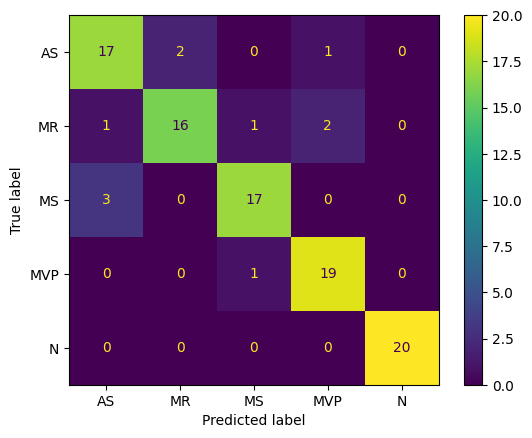

Accuracy : [0.93 0.94 0.95 0.96 1.  ] mean:  0.9560000000000001
Precision : [0.80952381 0.88888889 0.89473684 0.86363636 1.        ] mean:  0.8913571808308649
Sensitivity : [0.85 0.8  0.85 0.95 1.  ] mean:  0.89
Specificity : [0.95   0.975  0.975  0.9625 1.    ] mean:  0.9724999999999999
f1_score: [0.82926829 0.84210526 0.87179487 0.9047619  1.        ] mean:  0.8895860664795198



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb8L5.csv_5.h5
4/4 [==============================] - 0s 5ms/step


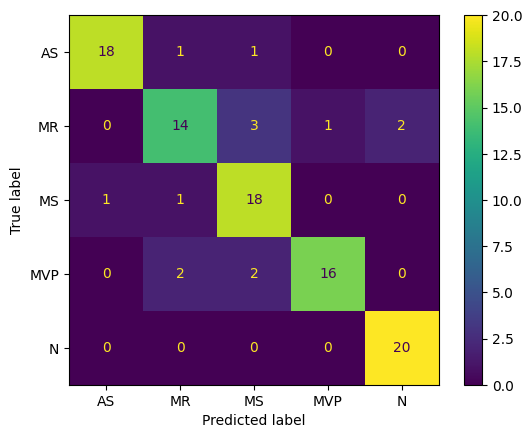

Accuracy : [0.97 0.9  0.92 0.95 0.98] mean:  0.9440000000000002
Precision : [0.94736842 0.77777778 0.75       0.94117647 0.90909091] mean:  0.8650827157019109
Sensitivity : [0.9 0.7 0.9 0.8 1. ] mean:  0.86
Specificity : [0.9875 0.95   0.925  0.9875 0.975 ] mean:  0.9649999999999999
f1_score: [0.92307692 0.73684211 0.81818182 0.86486486 0.95238095] mean:  0.8590693327535434



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb8L6.csv_5.h5
4/4 [==============================] - 0s 4ms/step


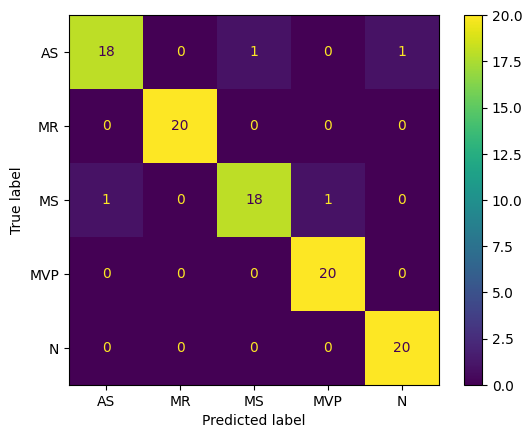

Accuracy : [0.97 1.   0.97 0.99 0.99] mean:  0.984
Precision : [0.94736842 1.         0.94736842 0.95238095 0.95238095] mean:  0.9598997493734336
Sensitivity : [0.9 1.  0.9 1.  1. ] mean:  0.96
Specificity : [0.9875 1.     0.9875 0.9875 0.9875] mean:  0.99
f1_score: [0.92307692 1.         0.92307692 0.97560976 0.97560976] mean:  0.9594746716697937



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb8L7.csv_5.h5
4/4 [==============================] - 0s 4ms/step


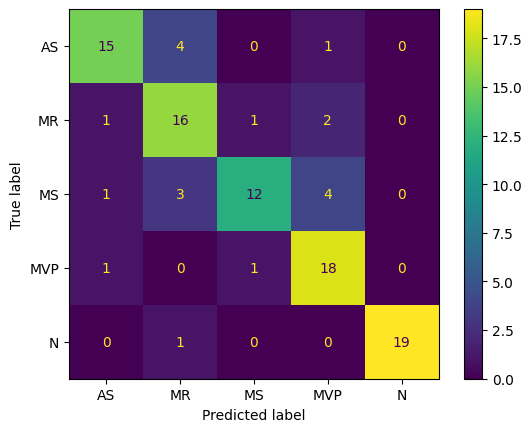

Accuracy : [0.92 0.88 0.9  0.91 0.99] mean:  0.9200000000000002
Precision : [0.83333333 0.66666667 0.85714286 0.72       1.        ] mean:  0.8154285714285715
Sensitivity : [0.75 0.8  0.6  0.9  0.95] mean:  0.8
Specificity : [0.9625 0.9    0.975  0.9125 1.    ] mean:  0.95
f1_score: [0.78947368 0.72727273 0.70588235 0.8        0.97435897] mean:  0.7993975477566808



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb8L8.csv_5.h5
4/4 [==============================] - 0s 5ms/step


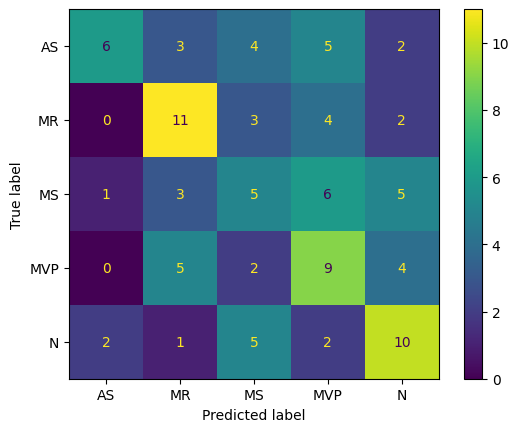

Accuracy : [0.83 0.79 0.71 0.72 0.77] mean:  0.764
Precision : [0.66666667 0.47826087 0.26315789 0.34615385 0.43478261] mean:  0.4378043771636449
Sensitivity : [0.3  0.55 0.25 0.45 0.5 ] mean:  0.41
Specificity : [0.9625 0.85   0.825  0.7875 0.8375] mean:  0.8525
f1_score: [0.4137931  0.51162791 0.25641026 0.39130435 0.46511628] mean:  0.4076503787462261



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb8L9.csv_5.h5
4/4 [==============================] - 0s 5ms/step


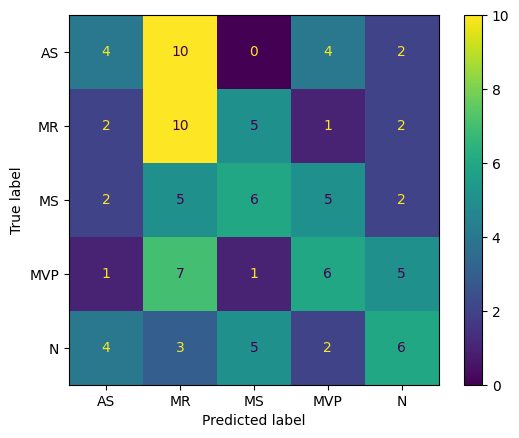

Accuracy : [0.75 0.65 0.75 0.74 0.75] mean:  0.728
Precision : [0.30769231 0.28571429 0.35294118 0.33333333 0.35294118] mean:  0.32652445593622065
Sensitivity : [0.2 0.5 0.3 0.3 0.3] mean:  0.32
Specificity : [0.8875 0.6875 0.8625 0.85   0.8625] mean:  0.8300000000000001
f1_score: [0.24242424 0.36363636 0.32432432 0.31578947 0.32432432] mean:  0.31409974567869303



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb8L10.csv_2.h5
4/4 [==============================] - 0s 5ms/step


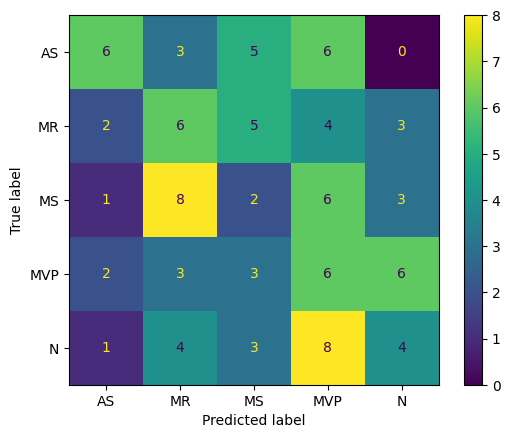

Accuracy : [0.8  0.68 0.66 0.62 0.72] mean:  0.6960000000000001
Precision : [0.5        0.25       0.11111111 0.2        0.25      ] mean:  0.26222222222222225
Sensitivity : [0.3 0.3 0.1 0.3 0.2] mean:  0.24
Specificity : [0.925 0.775 0.8   0.7   0.85 ] mean:  0.8099999999999999
f1_score: [0.375      0.27272727 0.10526316 0.24       0.22222222] mean:  0.24304253056884634



Accuracy All : [0.828, 0.788, 0.908, 0.9560000000000001, 0.9440000000000002, 0.984, 0.9200000000000002, 0.764, 0.728, 0.6960000000000001]
Precision All : [0.5735573122529644, 0.46557017543859647, 0.780641989589358, 0.8913571808308649, 0.8650827157019109, 0.9598997493734336, 0.8154285714285715, 0.4378043771636449, 0.32652445593622065, 0.26222222222222225]
Sensitivity All : [0.57, 0.4699999999999999, 0.77, 0.89, 0.86, 0.96, 0.8, 0.41, 0.32, 0.24]
Specificity All : [0.8924999999999998, 0.8674999999999999, 0.9425000000000001, 0.9724999999999999, 0.9649999999999999, 0.99, 0.95, 0.8525, 0.8300000000000001, 0.8099999999999

In [17]:
testingVHD(a8, 8)

Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb9L1.csv_5.h5


4/4 [==============================] - 0s 4ms/step


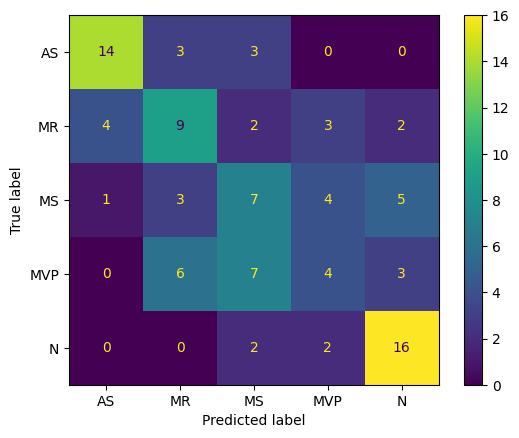

Accuracy : [0.89 0.77 0.73 0.75 0.86] mean:  0.8
Precision : [0.73684211 0.42857143 0.33333333 0.30769231 0.61538462] mean:  0.48436475804896856
Sensitivity : [0.7  0.45 0.35 0.2  0.8 ] mean:  0.5
Specificity : [0.9375 0.85   0.825  0.8875 0.875 ] mean:  0.875
f1_score: [0.71794872 0.43902439 0.34146341 0.24242424 0.69565217] mean:  0.48730258783281055



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb9L2.csv_5.h5
4/4 [==============================] - 0s 5ms/step


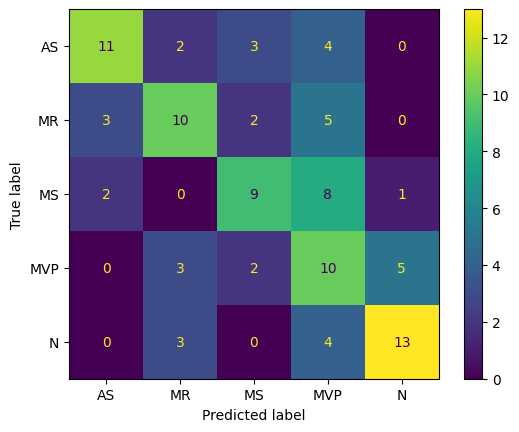

Accuracy : [0.86 0.82 0.82 0.69 0.87] mean:  0.8119999999999999
Precision : [0.6875     0.55555556 0.5625     0.32258065 0.68421053] mean:  0.562469345406527
Sensitivity : [0.55 0.5  0.45 0.5  0.65] mean:  0.53
Specificity : [0.9375 0.9    0.9125 0.7375 0.925 ] mean:  0.8825
f1_score: [0.61111111 0.52631579 0.5        0.39215686 0.66666667] mean:  0.539250085999312



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb9L3.csv_2.h5
4/4 [==============================] - 0s 5ms/step


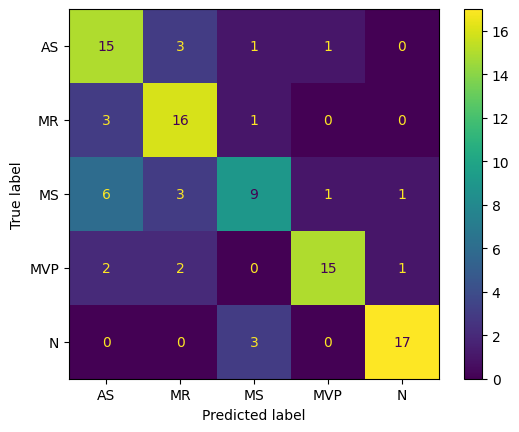

Accuracy : [0.84 0.88 0.84 0.93 0.95] mean:  0.8880000000000001
Precision : [0.57692308 0.66666667 0.64285714 0.88235294 0.89473684] mean:  0.7327073339457241
Sensitivity : [0.75 0.8  0.45 0.75 0.85] mean:  0.72
Specificity : [0.8625 0.9    0.9375 0.975  0.975 ] mean:  0.93
f1_score: [0.65217391 0.72727273 0.52941176 0.81081081 0.87179487] mean:  0.7182928175255541



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb9L4.csv_2.h5
4/4 [==============================] - 0s 5ms/step


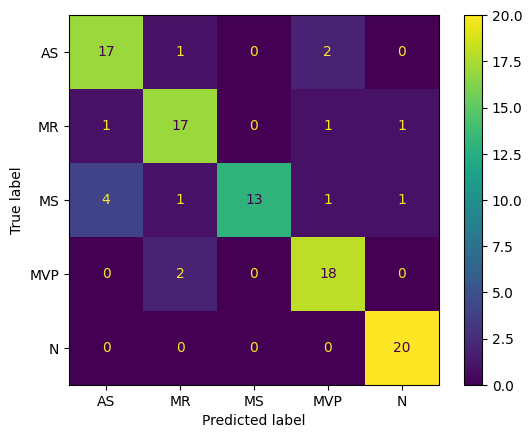

Accuracy : [0.92 0.93 0.93 0.94 0.98] mean:  0.9400000000000001
Precision : [0.77272727 0.80952381 1.         0.81818182 0.90909091] mean:  0.8619047619047618
Sensitivity : [0.85 0.85 0.65 0.9  1.  ] mean:  0.85
Specificity : [0.9375 0.95   1.     0.95   0.975 ] mean:  0.9625
f1_score: [0.80952381 0.82926829 0.78787879 0.85714286 0.95238095] mean:  0.8472389399218668



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb9L5.csv_2.h5
4/4 [==============================] - 0s 5ms/step


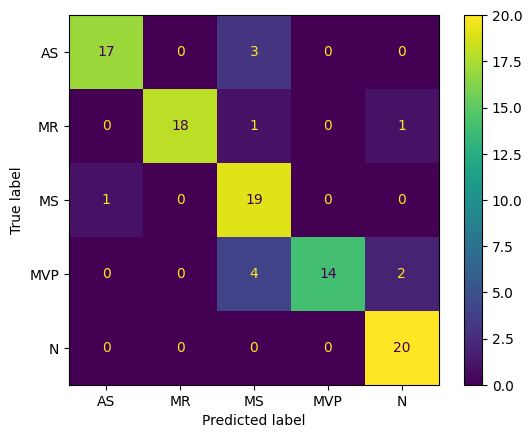

Accuracy : [0.96 0.98 0.91 0.94 0.97] mean:  0.952
Precision : [0.94444444 1.         0.7037037  1.         0.86956522] mean:  0.9035426731078905
Sensitivity : [0.85 0.9  0.95 0.7  1.  ] mean:  0.8800000000000001
Specificity : [0.9875 1.     0.9    1.     0.9625] mean:  0.9700000000000001
f1_score: [0.89473684 0.94736842 0.80851064 0.82352941 0.93023256] mean:  0.8808755742720015



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb9L6.csv_2.h5
4/4 [==============================] - 0s 4ms/step


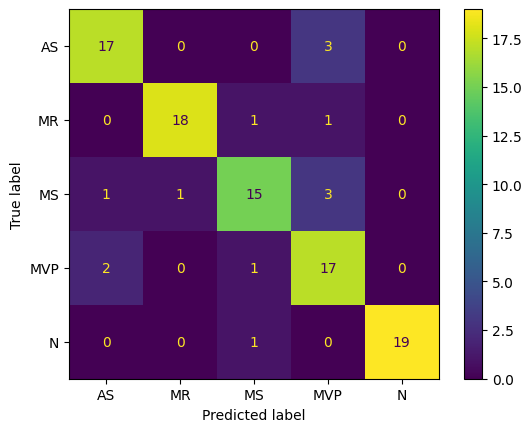

Accuracy : [0.94 0.97 0.92 0.9  0.99] mean:  0.944
Precision : [0.85       0.94736842 0.83333333 0.70833333 1.        ] mean:  0.8678070175438597
Sensitivity : [0.85 0.9  0.75 0.85 0.95] mean:  0.86
Specificity : [0.9625 0.9875 0.9625 0.9125 1.    ] mean:  0.9650000000000001
f1_score: [0.85       0.92307692 0.78947368 0.77272727 0.97435897] mean:  0.8619273708747393



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb9L7.csv_2.h5
4/4 [==============================] - 0s 6ms/step


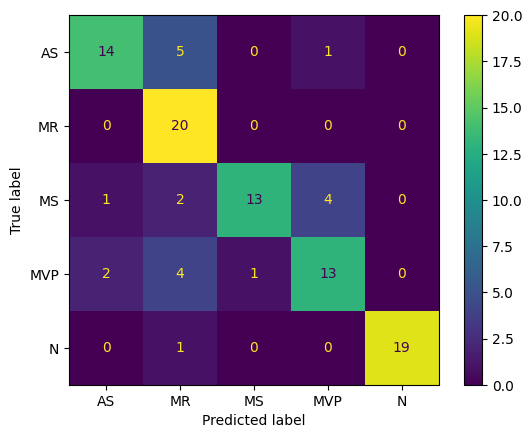

Accuracy : [0.91 0.88 0.92 0.88 0.99] mean:  0.916
Precision : [0.82352941 0.625      0.92857143 0.72222222 1.        ] mean:  0.8198646125116713
Sensitivity : [0.7  1.   0.65 0.65 0.95] mean:  0.79
Specificity : [0.9625 0.85   0.9875 0.9375 1.    ] mean:  0.9475
f1_score: [0.75675676 0.76923077 0.76470588 0.68421053 0.97435897] mean:  0.7898525818030462



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb9L8.csv_1.h5
4/4 [==============================] - 0s 5ms/step


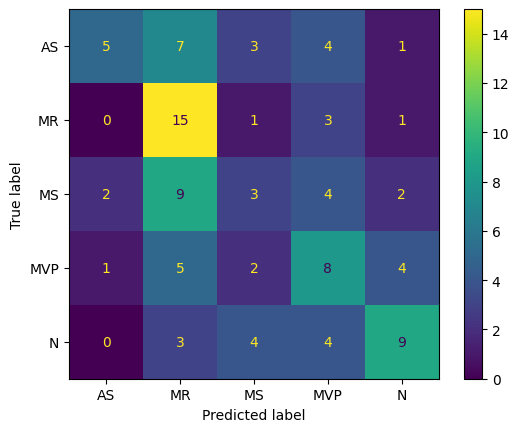

Accuracy : [0.82 0.71 0.73 0.73 0.81] mean:  0.76
Precision : [0.625      0.38461538 0.23076923 0.34782609 0.52941176] mean:  0.4235244934094039
Sensitivity : [0.25 0.75 0.15 0.4  0.45] mean:  0.39999999999999997
Specificity : [0.9625 0.7    0.875  0.8125 0.9   ] mean:  0.85
f1_score: [0.35714286 0.50847458 0.18181818 0.37209302 0.48648649] mean:  0.38120302499490516



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb9L9.csv_3.h5
4/4 [==============================] - 0s 5ms/step


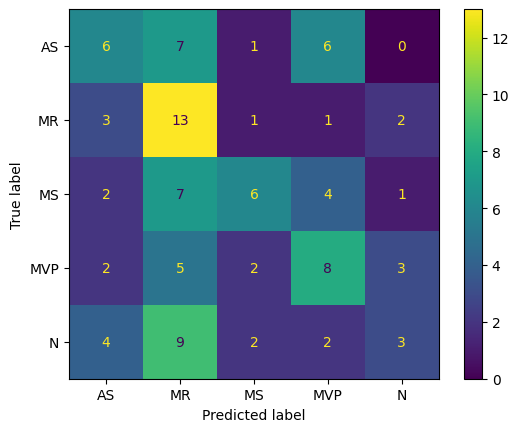

Accuracy : [0.75 0.65 0.8  0.75 0.77] mean:  0.744
Precision : [0.35294118 0.31707317 0.5        0.38095238 0.33333333] mean:  0.3768600122976019
Sensitivity : [0.3  0.65 0.3  0.4  0.15] mean:  0.36
Specificity : [0.8625 0.65   0.925  0.8375 0.925 ] mean:  0.8400000000000001
f1_score: [0.32432432 0.42622951 0.375      0.3902439  0.20689655] mean:  0.34453885733684164



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb9L10.csv_4.h5
4/4 [==============================] - 0s 5ms/step


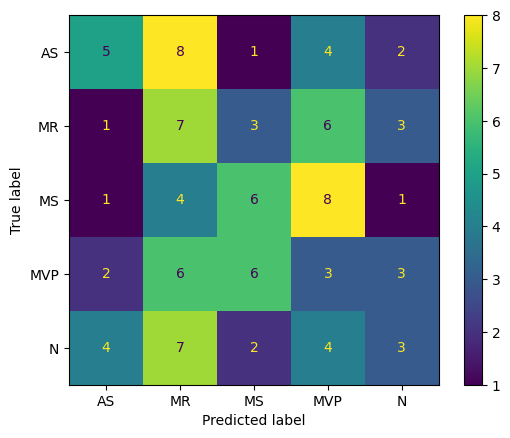

Accuracy : [0.77 0.62 0.74 0.61 0.74] mean:  0.696
Precision : [0.38461538 0.21875    0.33333333 0.12       0.25      ] mean:  0.26133974358974355
Sensitivity : [0.25 0.35 0.3  0.15 0.15] mean:  0.23999999999999994
Specificity : [0.9    0.6875 0.85   0.725  0.8875] mean:  0.8099999999999999
f1_score: [0.3030303  0.26923077 0.31578947 0.13333333 0.1875    ] mean:  0.2417767758557232



Accuracy All : [0.8, 0.8119999999999999, 0.8880000000000001, 0.9400000000000001, 0.952, 0.944, 0.916, 0.76, 0.744, 0.696]
Precision All : [0.48436475804896856, 0.562469345406527, 0.7327073339457241, 0.8619047619047618, 0.9035426731078905, 0.8678070175438597, 0.8198646125116713, 0.4235244934094039, 0.3768600122976019, 0.26133974358974355]
Sensitivity All : [0.5, 0.53, 0.72, 0.85, 0.8800000000000001, 0.86, 0.79, 0.39999999999999997, 0.36, 0.23999999999999994]
Specificity All : [0.875, 0.8825, 0.93, 0.9625, 0.9700000000000001, 0.9650000000000001, 0.9475, 0.85, 0.8400000000000001, 0.8099999999999999]
f1_score

In [18]:
testingVHD(a9, 9)

Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb10L1.csv_5.h5


4/4 [==============================] - 0s 5ms/step


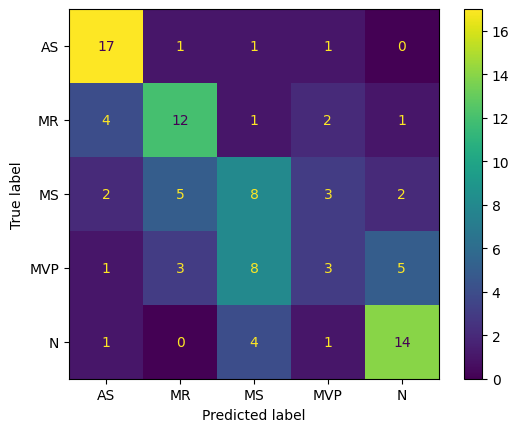

Accuracy : [0.89 0.83 0.74 0.76 0.86] mean:  0.8160000000000001
Precision : [0.68       0.57142857 0.36363636 0.3        0.63636364] mean:  0.5102857142857143
Sensitivity : [0.85 0.6  0.4  0.15 0.7 ] mean:  0.54
Specificity : [0.9    0.8875 0.825  0.9125 0.9   ] mean:  0.885
f1_score: [0.75555556 0.58536585 0.38095238 0.2        0.66666667] mean:  0.517708091366628



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb10L2.csv_4.h5
4/4 [==============================] - 0s 5ms/step


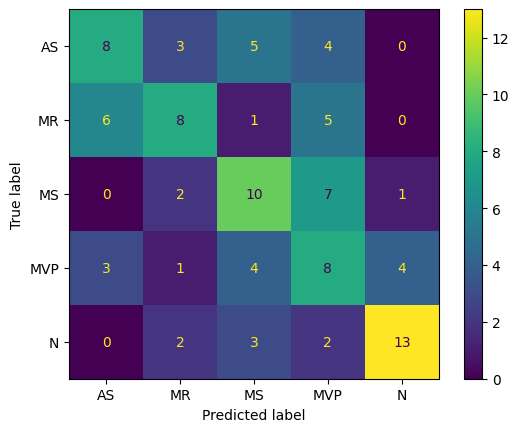

Accuracy : [0.79 0.8  0.77 0.7  0.88] mean:  0.788
Precision : [0.47058824 0.5        0.43478261 0.30769231 0.72222222] mean:  0.48705707478085997
Sensitivity : [0.4  0.4  0.5  0.4  0.65] mean:  0.47000000000000003
Specificity : [0.8875 0.9    0.8375 0.775  0.9375] mean:  0.8675
f1_score: [0.43243243 0.44444444 0.46511628 0.34782609 0.68421053] mean:  0.4748059538437911



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb10L3.csv_5.h5
4/4 [==============================] - 0s 5ms/step


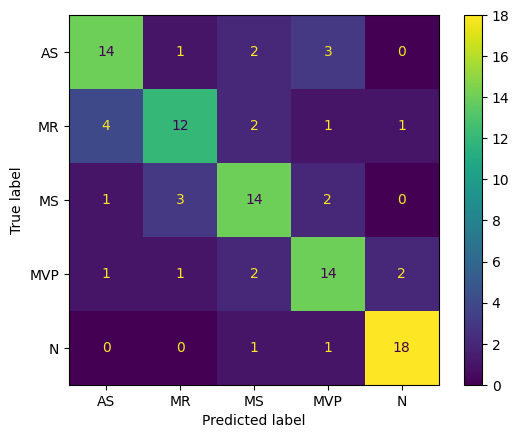

Accuracy : [0.88 0.87 0.87 0.87 0.95] mean:  0.8880000000000001
Precision : [0.7        0.70588235 0.66666667 0.66666667 0.85714286] mean:  0.7192717086834733
Sensitivity : [0.7 0.6 0.7 0.7 0.9] mean:  0.72
Specificity : [0.925  0.9375 0.9125 0.9125 0.9625] mean:  0.93
f1_score: [0.7        0.64864865 0.68292683 0.68292683 0.87804878] mean:  0.7185102175346076



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb10L4.csv_2.h5
4/4 [==============================] - 0s 4ms/step


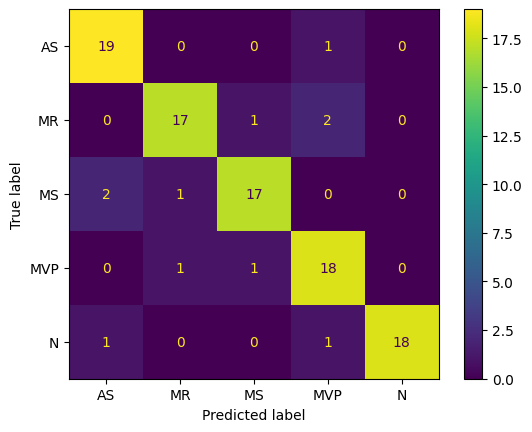

Accuracy : [0.96 0.95 0.95 0.94 0.98] mean:  0.9559999999999998
Precision : [0.86363636 0.89473684 0.89473684 0.81818182 1.        ] mean:  0.8942583732057416
Sensitivity : [0.95 0.85 0.85 0.9  0.9 ] mean:  0.89
Specificity : [0.9625 0.975  0.975  0.95   1.    ] mean:  0.9724999999999999
f1_score: [0.9047619  0.87179487 0.87179487 0.85714286 0.94736842] mean:  0.8905725853094275



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb10L5.csv_1.h5
4/4 [==============================] - 0s 5ms/step


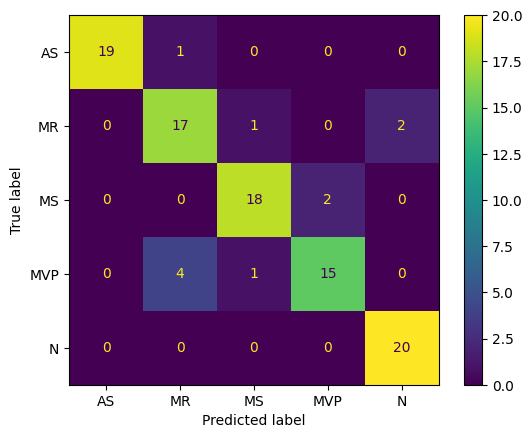

Accuracy : [0.99 0.92 0.96 0.93 0.98] mean:  0.9560000000000001
Precision : [1.         0.77272727 0.9        0.88235294 0.90909091] mean:  0.8928342245989305
Sensitivity : [0.95 0.85 0.9  0.75 1.  ] mean:  0.8899999999999999
Specificity : [1.     0.9375 0.975  0.975  0.975 ] mean:  0.9724999999999999
f1_score: [0.97435897 0.80952381 0.9        0.81081081 0.95238095] mean:  0.8894149094149094



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb10L6.csv_2.h5
4/4 [==============================] - 0s 5ms/step


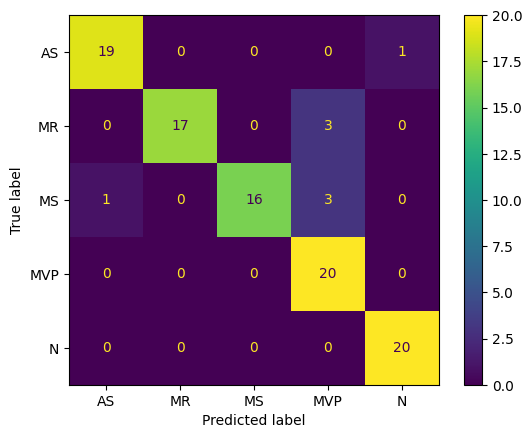

Accuracy : [0.98 0.97 0.96 0.94 0.99] mean:  0.968
Precision : [0.95       1.         1.         0.76923077 0.95238095] mean:  0.9343223443223444
Sensitivity : [0.95 0.85 0.8  1.   1.  ] mean:  0.9199999999999999
Specificity : [0.9875 1.     1.     0.925  0.9875] mean:  0.9799999999999999
f1_score: [0.95       0.91891892 0.88888889 0.86956522 0.97560976] mean:  0.9205965562593347



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb10L7.csv_2.h5
4/4 [==============================] - 0s 4ms/step


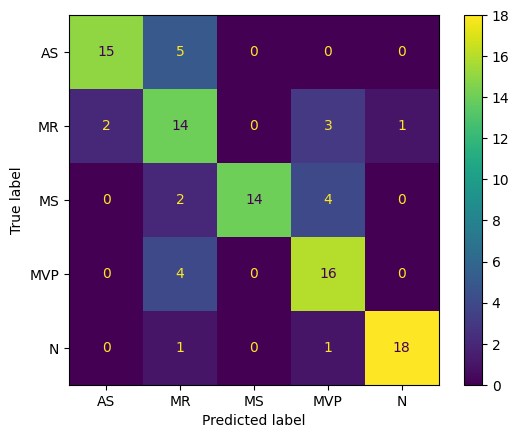

Accuracy : [0.93 0.82 0.94 0.88 0.97] mean:  0.908
Precision : [0.88235294 0.53846154 1.         0.66666667 0.94736842] mean:  0.8069699134714614
Sensitivity : [0.75 0.7  0.7  0.8  0.9 ] mean:  0.77
Specificity : [0.975  0.85   1.     0.9    0.9875] mean:  0.9425000000000001
f1_score: [0.81081081 0.60869565 0.82352941 0.72727273 0.92307692] mean:  0.7786771050198158



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb10L8.csv_2.h5
4/4 [==============================] - 0s 5ms/step


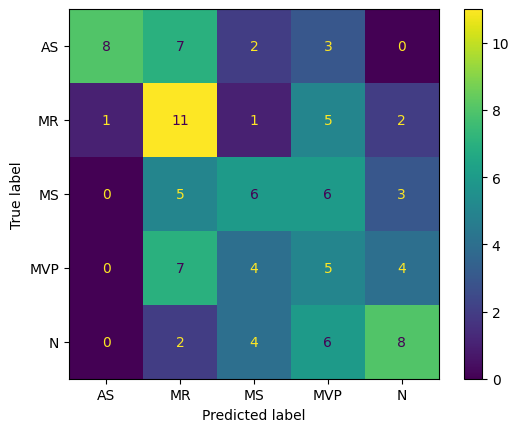

Accuracy : [0.87 0.7  0.75 0.65 0.79] mean:  0.752
Precision : [0.88888889 0.34375    0.35294118 0.2        0.47058824] mean:  0.4512336601307189
Sensitivity : [0.4  0.55 0.3  0.25 0.4 ] mean:  0.38
Specificity : [0.9875 0.7375 0.8625 0.75   0.8875] mean:  0.8450000000000001
f1_score: [0.55172414 0.42307692 0.32432432 0.22222222 0.43243243] mean:  0.39075600799738736



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb10L9.csv_2.h5
4/4 [==============================] - 0s 5ms/step


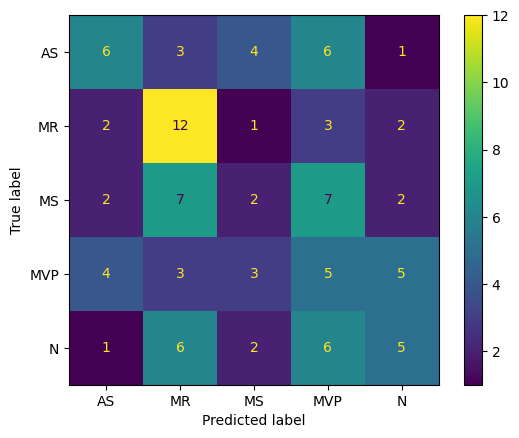

Accuracy : [0.77 0.73 0.72 0.63 0.75] mean:  0.72
Precision : [0.4        0.38709677 0.16666667 0.18518519 0.33333333] mean:  0.2944563918757467
Sensitivity : [0.3  0.6  0.1  0.25 0.25] mean:  0.3
Specificity : [0.8875 0.7625 0.875  0.725  0.875 ] mean:  0.825
f1_score: [0.34285714 0.47058824 0.125      0.21276596 0.28571429] mean:  0.287385124262471



Processing ../modelh5/RNN_NT/best_model/RNN_NT_KFold_data_MfccDwtChromaCqtdb10L10.csv_5.h5
4/4 [==============================] - 0s 5ms/step


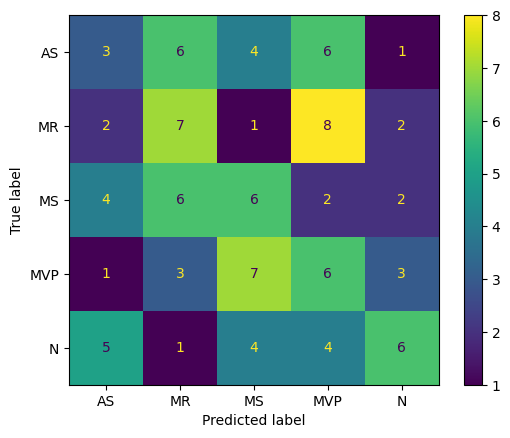

Accuracy : [0.71 0.71 0.7  0.66 0.78] mean:  0.7120000000000001
Precision : [0.2        0.30434783 0.27272727 0.23076923 0.42857143] mean:  0.28728315163097773
Sensitivity : [0.15 0.35 0.3  0.3  0.3 ] mean:  0.28
Specificity : [0.85 0.8  0.8  0.75 0.9 ] mean:  0.8200000000000001
f1_score: [0.17142857 0.3255814  0.28571429 0.26086957 0.35294118] mean:  0.27930699883593474



Accuracy All : [0.8160000000000001, 0.788, 0.8880000000000001, 0.9559999999999998, 0.9560000000000001, 0.968, 0.908, 0.752, 0.72, 0.7120000000000001]
Precision All : [0.5102857142857143, 0.48705707478085997, 0.7192717086834733, 0.8942583732057416, 0.8928342245989305, 0.9343223443223444, 0.8069699134714614, 0.4512336601307189, 0.2944563918757467, 0.28728315163097773]
Sensitivity All : [0.54, 0.47000000000000003, 0.72, 0.89, 0.8899999999999999, 0.9199999999999999, 0.77, 0.38, 0.3, 0.28]
Specificity All : [0.885, 0.8675, 0.93, 0.9724999999999999, 0.9724999999999999, 0.9799999999999999, 0.9425000000000001, 0.84500000000

In [19]:
testingVHD(a10, 10)